# 1.Import thư viện

In [1]:
pip install surprise

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: C:\Users\MSII\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
from surprise import Dataset, Reader, SVD, KNNBasic,KNNWithMeans
from surprise.model_selection import train_test_split as surprise_split
from surprise import accuracy
import joblib
from pymongo import MongoClient

# 2.Load data

## 2.1 Import dữ liệu

In [7]:
# user_df_ = pd.read_csv('_Users.csv')
# product_df_ = pd.read_csv('Products.csv')
# order_df_ = pd.read_csv('Orders.csv')
# order_items_df_ = pd.read_csv('Order_Items.csv')
# inventory_items_df_ = pd.read_csv('Inventory_Item.csv')
# event_df_ = pd.read_csv('Event.csv')

In [7]:
client = MongoClient('mongodb://localhost:27017/')  # Adjust the connection string as needed
db = client['E_commerce_Data']  # Replace with your database name

In [8]:
user_df_ = pd.DataFrame(list(db['users'].find()))  
product_df_ = pd.DataFrame(list(db['products'].find())) 
order_df_ = pd.DataFrame(list(db['orders'].find()))
order_items_df_ = pd.DataFrame(list(db['order_items'].find())) 
inventory_items_df_ = pd.DataFrame(list(db['inventory_items'].find()))  
event_df_ = pd.DataFrame(list(db['events'].find()))  

In [9]:
user_df = user_df_.copy()
product_df = product_df_.copy()
order_df = order_df_.copy()
order_items_df = order_items_df_.copy()
inventory_items_df = inventory_items_df_.copy()
event_df = event_df_.copy()

## 2.2 Mô tả dữ liệu

In [10]:
user_df.info()
user_df.shape
user_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99042 entries, 0 to 99041
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   _id             99042 non-null  object        
 1   id              99042 non-null  int64         
 2   first_name      99042 non-null  object        
 3   last_name       99042 non-null  object        
 4   email           99042 non-null  object        
 5   age             99042 non-null  int64         
 6   gender          99042 non-null  object        
 7   state           99042 non-null  object        
 8   street_address  99042 non-null  object        
 9   postal_code     99042 non-null  object        
 10  city            99042 non-null  object        
 11  country         99042 non-null  object        
 12  latitude        99042 non-null  float64       
 13  longitude       99042 non-null  float64       
 14  traffic_source  99042 non-null  object        
 15  cr

,id,age,latitude,longitude,created_at
count,99042.000000,99042.00000,99042.000000,99042.000000,99042
mean,50011.128642,41.04380,28.528946,25.671469,2021-07-31 05:06:01.621029120
min,1.000000,12.00000,-43.007536,-158.164931,2019-01-01 17:06:00
25%,25002.250000,26.00000,26.476449,-50.486332,2020-04-14 20:37:15
50%,50023.500000,41.00000,35.312641,5.156919,2021-08-02 22:26:00
75%,75015.750000,56.00000,40.738150,116.391848,2022-11-14 04:33:45
max,100000.000000,70.00000,64.865194,153.560238,2024-01-16 12:46:14
std,28871.285618,17.04341,21.932694,90.050029,NaN


In [11]:
user_df.head(10)

,_id,id,first_name,last_name,email,age,gender,state,street_address,postal_code,city,country,latitude,longitude,traffic_source,created_at
0,6694ca6cd5842db88bb685bb,457,Timothy,Bush,timothybush@example.net,65,M,Acre,87620 Johnson Hills,69917-400,Rio Branco,Brasil,-9.945568,-67.835610,Search,2022-07-19 06:51:00
1,6694ca6cd5842db88bb685bc,6578,Elizabeth,Martinez,elizabethmartinez@example.com,34,F,Acre,1705 Nielsen Land,69917-400,Rio Branco,Brasil,-9.945568,-67.835610,Search,2023-11-08 11:49:00
2,6694ca6cd5842db88bb685bd,36280,Christopher,Mendoza,christophermendoza@example.net,13,M,Acre,125 Turner Isle Apt. 264,69917-400,Rio Branco,Brasil,-9.945568,-67.835610,Email,2019-08-23 23:10:00
3,6694ca6cd5842db88bb685be,60193,Jimmy,Conner,jimmyconner@example.com,64,M,Acre,0966 Jose Branch Apt. 008,69917-400,Rio Branco,Brasil,-9.945568,-67.835610,Search,2020-02-15 04:26:00
4,6694ca6cd5842db88bb685bf,64231,Natasha,Wilson,natashawilson@example.net,25,F,Acre,20798 Phillip Trail Apt. 392,69917-400,Rio Branco,Brasil,-9.945568,-67.835610,Search,2020-03-12 23:45:00
5,6694ca6cd5842db88bb685c0,72187,Andrea,Bryant,andreabryant@example.org,47,F,Acre,622 Sims Field,69917-400,Rio Branco,Brasil,-9.945568,-67.835610,Search,2022-05-27 07:53:00
6,6694ca6cd5842db88bb685c1,22528,Keith,Barnett,keithbarnett@example.com,64,M,Acre,53908 Amy Fork Apt. 281,69940-000,Sena Madureira,Brasil,-9.857324,-69.437057,Search,2019-03-21 03:58:00
7,6694ca6cd5842db88bb685c2,34417,Joanne,Mcpherson,joannemcpherson@example.com,28,F,Acre,53907 John Unions Apt. 099,69940-000,Sena Madureira,Brasil,-9.857324,-69.437057,Search,2024-01-12 12:02:31
8,6694ca6cd5842db88bb685c3,50098,Ian,Burke,ianburke@example.net,52,M,Acre,91902 Andrea Stream Apt. 563,69940-000,Sena Madureira,Brasil,-9.857324,-69.437057,Email,2019-04-11 23:11:00
9,6694ca6cd5842db88bb685c4,63352,David,Orozco,davidorozco@example.org,18,M,Acre,9576 Dominique Run,69940-000,Sena Madureira,Brasil,-9.857324,-69.437057,Search,2023-10-29 05:33:00


In [12]:
product_df.info()
product_df.shape
product_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29094 entries, 0 to 29093
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   _id                     29094 non-null  object 
 1   id                      29094 non-null  int64  
 2   cost                    29094 non-null  float64
 3   category                29094 non-null  object 
 4   name                    29094 non-null  object 
 5   brand                   29094 non-null  object 
 6   retail_price            29094 non-null  float64
 7   department              29094 non-null  object 
 8   sku                     29094 non-null  object 
 9   distribution_center_id  29094 non-null  int64  
dtypes: float64(2), int64(2), object(6)
memory usage: 2.2+ MB


,id,cost,retail_price,distribution_center_id
count,29094.000000,29094.000000,29094.000000,29094.000000
mean,14558.540764,28.490452,59.239441,4.984773
std,8406.897280,30.634308,65.909439,2.901743
min,1.000000,0.008300,0.020000,1.000000
25%,7276.250000,11.275338,24.000000,2.000000
50%,14558.500000,19.688765,39.990002,5.000000
75%,21838.750000,34.450375,69.949997,8.000000
max,29120.000000,557.151002,999.000000,10.000000


In [13]:
order_df.info()
order_df.shape
order_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125226 entries, 0 to 125225
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   _id           125226 non-null  object        
 1   order_id      125226 non-null  int64         
 2   user_id       125226 non-null  int64         
 3   status        125226 non-null  object        
 4   gender        125226 non-null  object        
 5   created_at    125226 non-null  datetime64[ns]
 6   num_of_item   125226 non-null  int64         
 7   shipped_at    81461 non-null   datetime64[ns]
 8   delivered_at  43884 non-null   datetime64[ns]
 9   returned_at   12530 non-null   datetime64[ns]
dtypes: datetime64[ns](4), int64(3), object(3)
memory usage: 9.6+ MB


,order_id,user_id,created_at,num_of_item,shipped_at,delivered_at,returned_at
count,125226.000000,125226.000000,125226,125226.000000,81461,43884,12530
mean,62613.500000,50010.104355,2022-10-24 17:25:31.415376896,1.451448,2022-10-25 16:00:54.378647040,2022-10-28 15:09:58.737330432,2022-10-31 17:56:00.786352640
min,1.000000,1.000000,2019-01-05 22:30:00,1.000000,2019-01-08 21:36:00,2019-01-17 21:47:00,2019-01-20 20:46:00
25%,31307.250000,25062.250000,2022-02-26 00:50:00,1.000000,2022-02-27 07:59:00,2022-03-02 05:12:15,2022-03-04 00:01:00
50%,62613.500000,50051.000000,2023-02-20 01:08:00,1.000000,2023-02-20 17:52:00,2023-02-24 19:21:30,2023-03-01 20:06:00
75%,93919.750000,74918.750000,2023-09-26 02:51:30,2.000000,2023-09-28 01:47:00,2023-09-30 02:23:45,2023-10-03 09:54:45
max,125226.000000,100000.000000,2024-01-17 12:46:14,4.000000,2024-01-20 10:57:00,2024-01-24 15:14:42,2024-01-26 22:16:19
std,36149.776742,28849.881537,NaN,0.808190,NaN,NaN,NaN


In [16]:
order_df.sample(10)

,_id,order_id,user_id,status,gender,created_at,num_of_item,shipped_at,delivered_at,returned_at
55852,6694c884d5842db88bb576bc,80471,64174,Shipped,F,2022-11-01 18:47:00,2,2022-11-02 03:15:00,NaT,NaT
71840,6694c884d5842db88bb5b530,122944,98158,Cancelled,M,2023-11-14 11:32:00,2,NaT,NaT,NaT
20267,6694c882d5842db88bb4ebbb,87868,70049,Complete,F,2023-10-16 20:54:00,2,2023-10-18 03:25:00,2023-10-18 04:45:00,NaT
25456,6694c882d5842db88bb50000,5368,4246,Processing,F,2020-12-06 05:55:00,1,NaT,NaT,NaT
79407,6694c885d5842db88bb5d2bf,57174,45792,Complete,M,2023-11-13 08:38:00,1,2023-11-15 05:01:00,2023-11-18 18:34:00,NaT
29702,6694c882d5842db88bb51096,48107,38486,Processing,F,2021-10-05 07:19:00,1,NaT,NaT,NaT
37310,6694c883d5842db88bb52e4e,122987,98190,Processing,F,2022-04-29 18:26:00,1,NaT,NaT,NaT
61297,6694c884d5842db88bb58c01,115957,92614,Shipped,F,2022-08-17 04:13:00,4,2022-08-19 22:31:00,NaT,NaT
85168,6694c885d5842db88bb5e940,104187,83201,Complete,M,2023-09-13 02:11:00,2,2023-09-13 02:37:00,2023-09-13 12:31:00,NaT
87755,6694c885d5842db88bb5f35b,22,15,Processing,M,2022-06-16 01:38:00,1,NaT,NaT,NaT


In [14]:
order_items_df.info()
order_items_df.shape
order_items_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181759 entries, 0 to 181758
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   _id                181759 non-null  object        
 1   id                 181759 non-null  int64         
 2   order_id           181759 non-null  int64         
 3   user_id            181759 non-null  int64         
 4   product_id         181759 non-null  int64         
 5   inventory_item_id  181759 non-null  int64         
 6   status             181759 non-null  object        
 7   created_at         181759 non-null  datetime64[ns]
 8   sale_price         181759 non-null  float64       
 9   shipped_at         118281 non-null  datetime64[ns]
 10  delivered_at       63841 non-null   datetime64[ns]
 11  returned_at        18232 non-null   datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(5), object(2)
memory usage: 16.6+ MB


,id,order_id,user_id,product_id,inventory_item_id,created_at,sale_price,shipped_at,delivered_at,returned_at
count,181759.000000,181759.000000,181759.000000,181759.000000,181759.000000,181759,181759.000000,118281,63841,18232
mean,90880.000000,62579.982609,49983.272020,15254.151838,245291.860007,2022-10-24 10:46:02.956580352,59.568544,2022-10-24 20:35:10.054150656,2022-10-27 16:47:53.170971904,2022-10-30 16:01:59.253236224
min,1.000000,1.000000,1.000000,1.000000,3.000000,2019-01-05 19:25:41,0.020000,2019-01-08 21:36:00,2019-01-17 21:47:00,2019-01-20 20:46:00
25%,45440.500000,31266.500000,25031.500000,7979.500000,122565.000000,2022-02-24 03:16:22,24.500000,2022-02-25 08:28:00,2022-02-28 05:39:00,2022-02-28 01:49:15
50%,90880.000000,62529.000000,49983.000000,15966.000000,245284.000000,2023-02-20 18:19:27,39.990002,2023-02-20 20:39:00,2023-02-24 16:08:00,2023-03-02 22:18:00
75%,136319.500000,93845.500000,74867.500000,22504.000000,367983.000000,2023-09-26 20:51:44.500000,69.949997,2023-09-27 12:19:00,2023-09-29 21:30:00,2023-10-03 13:22:15
max,181759.000000,125226.000000,100000.000000,29120.000000,490705.000000,2024-01-21 11:02:23,999.000000,2024-01-20 10:57:00,2024-01-24 15:14:42,2024-01-26 22:16:19
std,52469.448126,36125.987285,28830.895739,8413.482833,141661.912894,NaN,66.657262,NaN,NaN,NaN


In [15]:
inventory_items_df.info()
inventory_items_df.shape
inventory_items_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490676 entries, 0 to 490675
Data columns (total 13 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   _id                             490676 non-null  object        
 1   id                              490676 non-null  int64         
 2   product_id                      490676 non-null  int64         
 3   created_at                      490676 non-null  datetime64[ns]
 4   sold_at                         181749 non-null  datetime64[ns]
 5   cost                            490676 non-null  float64       
 6   product_category                490676 non-null  object        
 7   product_name                    490676 non-null  object        
 8   product_brand                   490676 non-null  object        
 9   product_retail_price            490676 non-null  float64       
 10  product_department              490676 non-null  object 

,id,product_id,created_at,sold_at,cost,product_retail_price,product_distribution_center_id
count,490676.000000,490676.000000,490676,181749,490676.000000,490676.000000,490676.000000
mean,245352.382886,15254.007702,2022-04-14 13:57:12.172327680,2022-10-24 10:38:43.212281344,28.658277,59.567866,5.011725
min,1.000000,1.000000,2018-11-07 21:14:18,2019-01-05 19:25:41,0.008300,0.020000,1.000000
25%,122677.750000,7983.000000,2021-04-16 09:29:59.750000128,2022-02-24 03:00:52,11.368000,24.500000,2.000000
50%,245352.500000,15971.000000,2022-06-08 00:33:00,2023-02-20 18:17:03,19.832000,39.990002,5.000000
75%,368030.250000,22501.000000,2023-05-12 17:43:50.249999872,2023-09-26 20:47:52,34.550301,69.949997,8.000000
max,490705.000000,29120.000000,2024-01-20 20:29:15,2024-01-21 11:02:23,557.151002,999.000000,10.000000
std,141654.652594,8410.687577,NaN,NaN,31.009663,66.592729,2.899969


In [16]:
event_df.info()
event_df.shape
event_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1294116 entries, 0 to 1294115
Data columns (total 14 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   _id              1294116 non-null  object        
 1   id               1294116 non-null  int64         
 2   user_id          1294116 non-null  float64       
 3   sequence_number  1294116 non-null  int64         
 4   session_id       1294116 non-null  object        
 5   created_at       1294116 non-null  datetime64[ns]
 6   ip_address       1294116 non-null  object        
 7   city             1294116 non-null  object        
 8   state            1294116 non-null  object        
 9   postal_code      1294116 non-null  object        
 10  browser          1294116 non-null  object        
 11  traffic_source   1294116 non-null  object        
 12  uri              1294116 non-null  object        
 13  event_type       1294116 non-null  object        
dtypes:

,id,user_id,sequence_number,created_at
count,1.294116e+06,1.294116e+06,1.294116e+06,1294116
mean,6.533941e+05,4.998531e+04,4.640890e+00,2022-10-22 02:51:58.739751168
min,1.000000e+00,1.000000e+00,1.000000e+00,2019-01-05 19:16:07
25%,3.266438e+05,2.501100e+04,2.000000e+00,2022-02-19 07:53:55.500000
50%,6.534805e+05,4.995500e+04,4.000000e+00,2023-02-19 02:09:38
75%,9.801462e+05,7.487800e+04,6.000000e+00,2023-09-25 03:21:23.500000
max,1.306292e+06,1.000000e+05,1.300000e+01,2024-01-21 11:02:23
std,3.772000e+05,2.882525e+04,3.000999e+00,NaN


# 3.Data Preprocessing

## 3.1 Data Cleaning

### 3.1.1 Xử lý dữ liệu bị thiếu

In [6]:
# Kiểm tra dữ liệu bị thiếu

In [5]:
user_df.isnull().sum()

_id               0
id                0
first_name        0
last_name         0
email             0
age               0
gender            0
state             0
street_address    0
postal_code       0
city              0
country           0
latitude          0
longitude         0
traffic_source    0
created_at        0
dtype: int64

In [8]:
product_df.isnull().sum()

_id                       0
id                        0
cost                      0
category                  0
name                      0
brand                     0
retail_price              0
department                0
sku                       0
distribution_center_id    0
dtype: int64

In [9]:
order_df.isnull().sum()

_id                  0
order_id             0
user_id              0
status               0
gender               0
created_at           0
num_of_item          0
shipped_at       43765
delivered_at     81342
returned_at     112696
dtype: int64

In [10]:
order_items_df.isnull().sum()

_id                       0
id                        0
order_id                  0
user_id                   0
product_id                0
inventory_item_id         0
status                    0
created_at                0
sale_price                0
shipped_at            63478
delivered_at         117918
returned_at          163527
dtype: int64

In [11]:
inventory_items_df.isnull().sum()

_id                                    0
id                                     0
product_id                             0
created_at                             0
sold_at                           308927
cost                                   0
product_category                       0
product_name                           0
product_brand                          0
product_retail_price                   0
product_department                     0
product_sku                            0
product_distribution_center_id         0
dtype: int64

In [12]:
event_df.isnull().sum()

_id                0
id                 0
user_id            0
sequence_number    0
session_id         0
created_at         0
ip_address         0
city               0
state              0
postal_code        0
browser            0
traffic_source     0
uri                0
event_type         0
dtype: int64

In [13]:
#Xử lý dữ liệu thời gian

In [6]:
inventory_items_df['sold_at'] = inventory_items_df['sold_at'].fillna(pd.Timestamp('1970-01-01'))
order_df[['returned_at','shipped_at','delivered_at']] =order_df[['returned_at','shipped_at','delivered_at']].fillna(pd.Timestamp('1970-01-01'))
order_items_df[['returned_at','shipped_at','delivered_at']] =order_items_df[['returned_at','shipped_at','delivered_at']].fillna(pd.Timestamp('1970-01-01'))

### 3.1.2 Xử lý dữ liệu bị trùng

In [15]:
#Kiểm tra dữ liệu bị trùng

In [16]:
user_df.duplicated().sum()

0

In [17]:
product_df.duplicated().sum()

0

In [18]:
order_df.duplicated().sum()

0

In [19]:
order_items_df.duplicated().sum()

0

In [20]:
inventory_items_df.duplicated().sum()

0

In [21]:
event_df.duplicated().sum()

0

## 3.2 Data Integration

### 3.2.1 Tổng hợp dữ liệu

In [7]:
user_df = user_df.rename(columns={'id': 'user_id',
                                 'created_at':'user_created_at'})

master_df = order_df.merge(user_df,how = 'inner',on = 'user_id')

In [8]:
master_df[master_df.duplicated(subset=['gender_x', 'gender_y'], keep=False)]

,_id_x,order_id,user_id,status,gender_x,created_at,num_of_item,shipped_at,delivered_at,returned_at,...,gender_y,state,street_address,postal_code,city,country,latitude,longitude,traffic_source,user_created_at
0,6694c881d5842db88bb49c90,8,5,Cancelled,F,2022-10-20 03:03:00,3,1970-01-01 00:00:00,1970-01-01,1970-01-01,...,F,Piauí,609 Susan Row,64120-000,União,Brasil,-4.594783,-42.789899,Organic,2020-10-02 03:03:00
1,6694c881d5842db88bb49c91,60,44,Cancelled,F,2023-01-19 19:12:00,1,1970-01-01 00:00:00,1970-01-01,1970-01-01,...,F,Chung-cheong bukdo,282 Karen Grove Suite 885,360-100,Cheongju City,South Korea,36.617142,127.519227,Search,2022-08-15 19:12:00
2,6694c881d5842db88bb49c92,64,46,Cancelled,F,2021-12-06 02:11:00,1,1970-01-01 00:00:00,1970-01-01,1970-01-01,...,F,New York,22127 Dennis Prairie Apt. 844,10474,New York,United States,40.804627,-73.882919,Search,2020-01-07 02:11:00
3,6694c881d5842db88bb49c93,89,65,Cancelled,F,2020-08-13 02:58:00,1,1970-01-01 00:00:00,1970-01-01,1970-01-01,...,F,Ningxia Hui Autonomous Region,504 Warner Brook,750000,Shenzhen,China,38.507578,106.315768,Organic,2019-03-13 02:58:00
4,6694c881d5842db88bb49c94,102,76,Cancelled,F,2023-01-17 01:17:00,2,1970-01-01 00:00:00,1970-01-01,1970-01-01,...,F,Chiba,343 James Trail,290-0067,City of the city,Japan,35.547434,140.097163,Organic,2022-09-07 01:17:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124067,6694c887d5842db88bb685b5,125196,99972,Shipped,M,2022-06-25 04:56:00,1,2022-06-28 01:24:00,1970-01-01,1970-01-01,...,M,Île-de-France,319 Donaldson Fort Suite 360,92160,Antony,France,48.750021,2.299056,Organic,2021-12-14 04:56:00
124068,6694c887d5842db88bb685b6,125199,99975,Shipped,M,2022-07-19 19:19:00,4,2022-07-22 04:08:00,1970-01-01,1970-01-01,...,M,New Jersey,191 John Ridge,7030,Hoboken,United States,40.743946,-74.029352,Search,2019-12-27 19:19:00
124069,6694c887d5842db88bb685b7,125208,99983,Shipped,M,2022-03-14 08:06:00,1,2022-03-16 22:15:00,1970-01-01,1970-01-01,...,M,Beijing,400 Stacy Curve,101509,Shanghai,China,40.351331,116.792066,Search,2022-02-27 08:06:00
124070,6694c887d5842db88bb685b8,125210,99983,Shipped,M,2023-03-01 08:06:00,2,2023-03-02 03:50:00,1970-01-01,1970-01-01,...,M,Beijing,400 Stacy Curve,101509,Shanghai,China,40.351331,116.792066,Search,2022-02-27 08:06:00


In [9]:
master_df = master_df.drop('gender_x',axis =1)

In [10]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124072 entries, 0 to 124071
Data columns (total 24 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   _id_x            124072 non-null  object        
 1   order_id         124072 non-null  int64         
 2   user_id          124072 non-null  int64         
 3   status           124072 non-null  object        
 4   created_at       124072 non-null  datetime64[ns]
 5   num_of_item      124072 non-null  int64         
 6   shipped_at       124072 non-null  datetime64[ns]
 7   delivered_at     124072 non-null  datetime64[ns]
 8   returned_at      124072 non-null  datetime64[ns]
 9   _id_y            124072 non-null  object        
 10  first_name       124072 non-null  object        
 11  last_name        124072 non-null  object        
 12  email            124072 non-null  object        
 13  age              124072 non-null  int64         
 14  gender_y         124

In [11]:
master_df = master_df.merge(order_items_df[['order_id','product_id','inventory_item_id','sale_price']],how = 'inner',on ='order_id')

In [12]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180078 entries, 0 to 180077
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   _id_x              180078 non-null  object        
 1   order_id           180078 non-null  int64         
 2   user_id            180078 non-null  int64         
 3   status             180078 non-null  object        
 4   created_at         180078 non-null  datetime64[ns]
 5   num_of_item        180078 non-null  int64         
 6   shipped_at         180078 non-null  datetime64[ns]
 7   delivered_at       180078 non-null  datetime64[ns]
 8   returned_at        180078 non-null  datetime64[ns]
 9   _id_y              180078 non-null  object        
 10  first_name         180078 non-null  object        
 11  last_name          180078 non-null  object        
 12  email              180078 non-null  object        
 13  age                180078 non-null  int64   

In [13]:
product_df = product_df.rename(columns={'id': 'product_id',})

master_df = master_df.merge(product_df,how = 'left',on ='product_id')

In [14]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180078 entries, 0 to 180077
Data columns (total 36 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   _id_x                   180078 non-null  object        
 1   order_id                180078 non-null  int64         
 2   user_id                 180078 non-null  int64         
 3   status                  180078 non-null  object        
 4   created_at              180078 non-null  datetime64[ns]
 5   num_of_item             180078 non-null  int64         
 6   shipped_at              180078 non-null  datetime64[ns]
 7   delivered_at            180078 non-null  datetime64[ns]
 8   returned_at             180078 non-null  datetime64[ns]
 9   _id_y                   180078 non-null  object        
 10  first_name              180078 non-null  object        
 11  last_name               180078 non-null  object        
 12  email                   180078

In [15]:
master_df.isnull().sum()

_id_x                       0
order_id                    0
user_id                     0
status                      0
created_at                  0
num_of_item                 0
shipped_at                  0
delivered_at                0
returned_at                 0
_id_y                       0
first_name                  0
last_name                   0
email                       0
age                         0
gender_y                    0
state                       0
street_address              0
postal_code                 0
city                        0
country                     0
latitude                    0
longitude                   0
traffic_source              0
user_created_at             0
product_id                  0
inventory_item_id           0
sale_price                  0
_id                       158
cost                      158
category                  158
name                      158
brand                     158
retail_price              158
department

In [16]:
master_df = master_df.dropna()

In [17]:
master_df.duplicated().sum()

0

## 3.3 Data Transformation

### 3.3.1 Chuẩn hóa dữ liệu

In [18]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 179920 entries, 0 to 180077
Data columns (total 36 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   _id_x                   179920 non-null  object        
 1   order_id                179920 non-null  int64         
 2   user_id                 179920 non-null  int64         
 3   status                  179920 non-null  object        
 4   created_at              179920 non-null  datetime64[ns]
 5   num_of_item             179920 non-null  int64         
 6   shipped_at              179920 non-null  datetime64[ns]
 7   delivered_at            179920 non-null  datetime64[ns]
 8   returned_at             179920 non-null  datetime64[ns]
 9   _id_y                   179920 non-null  object        
 10  first_name              179920 non-null  object        
 11  last_name               179920 non-null  object        
 12  email                   179920 non-

In [19]:
master_df.head(10)

,_id_x,order_id,user_id,status,created_at,num_of_item,shipped_at,delivered_at,returned_at,_id_y,...,sale_price,_id,cost,category,name,brand,retail_price,department,sku,distribution_center_id
0,6694c881d5842db88bb49c90,8,5,Cancelled,2022-10-20 03:03:00,3,1970-01-01,1970-01-01,1970-01-01,6694ca6fd5842db88bb79c8c,...,15.670000,6694c81dd5842db88bb43c73,7.443250,Shorts,Grane Supergirl Shorts,Grane,15.670000,Women,b'=H\x93A\x9eWD\x9f\xb2\x90dqI\xf78\xd4',2.0
1,6694c881d5842db88bb49c90,8,5,Cancelled,2022-10-20 03:03:00,3,1970-01-01,1970-01-01,1970-01-01,6694ca6fd5842db88bb79c8c,...,24.990000,6694c81dd5842db88bb46854,10.470810,Skirts,Woman Within Plus Size Petite flare skirt,Woman Within,24.990000,Women,162D18156ABE38A3B32851B72B1D44F5,5.0
2,6694c881d5842db88bb49c90,8,5,Cancelled,2022-10-20 03:03:00,3,1970-01-01,1970-01-01,1970-01-01,6694ca6fd5842db88bb79c8c,...,24.990000,6694c81dd5842db88bb468b0,10.895640,Sweaters,LookbookStore Women Coloured Zip Mouth Smile S...,LookbookStore,24.990000,Women,8A146F1A3DA4700CBF03CDC55E2DAAE6,5.0
3,6694c881d5842db88bb49c91,60,44,Cancelled,2023-01-19 19:12:00,1,1970-01-01,1970-01-01,1970-01-01,6694ca6dd5842db88bb6c70d,...,16.990000,6694c81dd5842db88bb4560e,6.677070,Maternity,Lace Cami Top and Boxer Shorts Lingerie Set,Angelina Hosiery,16.990000,Women,0563CAD67522FC198DEE8690630E475A,3.0
4,6694c881d5842db88bb49c92,64,46,Cancelled,2021-12-06 02:11:00,1,1970-01-01,1970-01-01,1970-01-01,6694ca6fd5842db88bb77781,...,36.000000,6694c81dd5842db88bb451db,22.068000,Sleep & Lounge,Calvin Klein Women's Nocturnal Elegance Camisole,Calvin Klein,36.000000,Women,0A66E17D3CCDE15BDECB253E7E293294,3.0
5,6694c881d5842db88bb49c93,89,65,Cancelled,2020-08-13 02:58:00,1,1970-01-01,1970-01-01,1970-01-01,6694ca6fd5842db88bb77cce,...,49.990002,6694c81dd5842db88bb4445e,27.094581,Tops & Tees,Alternative Ladies' Rib-Sleeve Scoopneck Long-...,Alternative,49.990002,Women,47D1E990583C9C67424D369F3414728E,2.0
6,6694c881d5842db88bb49c94,102,76,Cancelled,2023-01-17 01:17:00,2,1970-01-01,1970-01-01,1970-01-01,6694ca6dd5842db88bb6c4a7,...,5.900000,6694c81dd5842db88bb47c01,3.817300,Leggings,White Seamless Capri Leggings Three Quarter Le...,FineBrandShop,5.900000,Women,05AE14D7AE387B93370D142D82220F1B,7.0
7,6694c881d5842db88bb49c94,102,76,Cancelled,2023-01-17 01:17:00,2,1970-01-01,1970-01-01,1970-01-01,6694ca6dd5842db88bb6c4a7,...,37.290001,6694c81dd5842db88bb44050,17.973780,Intimates,Bra & panty set,Coquette,37.290001,Women,00BBD6BEACE7365B27A913DB75FDDCE9,2.0
8,6694c881d5842db88bb49c95,117,89,Cancelled,2023-07-31 06:25:00,1,1970-01-01,1970-01-01,1970-01-01,6694ca71d5842db88bb80745,...,43.990002,6694c81dd5842db88bb46fb7,23.270711,Plus,Glamorise Women's Full-Figure Sports Bra #1006,Glamorise,43.990002,Women,09F6F87F06F60E9A8D8F633C84C381F2,6.0
9,6694c881d5842db88bb49c96,143,118,Cancelled,2020-04-20 19:59:00,1,1970-01-01,1970-01-01,1970-01-01,6694ca70d5842db88bb7f818,...,52.000000,6694c81ed5842db88bb47e0e,31.512000,Sleep & Lounge,Karen Nueburger Women's Plus-Size Pop Long Sle...,Karen Nueburger,52.000000,Women,1B932EAF9F7C0CB84F471A560097DDB8,7.0


In [20]:
#Chuẩn hóa status
status_mapping = {
    'Cancelled': 1,
    'Complete': 5,
    'Processing': 3,
    'Returned': 2,
    'Shipped': 4
}
# Create a new column with the normalized values
master_df['status_normalized'] = master_df['status'].map(status_mapping)

In [21]:
#Chuẩn hóa gender
master_df = master_df.rename(columns={'gender_y': 'gender'})
gender_mapping = {
    'F': 1,
    'M': 0
}

# Create a new column with the normalized values
master_df['gender'] = master_df['gender'].map(gender_mapping)

### 3.3.2 Xử lý dữ liệu dư thừa

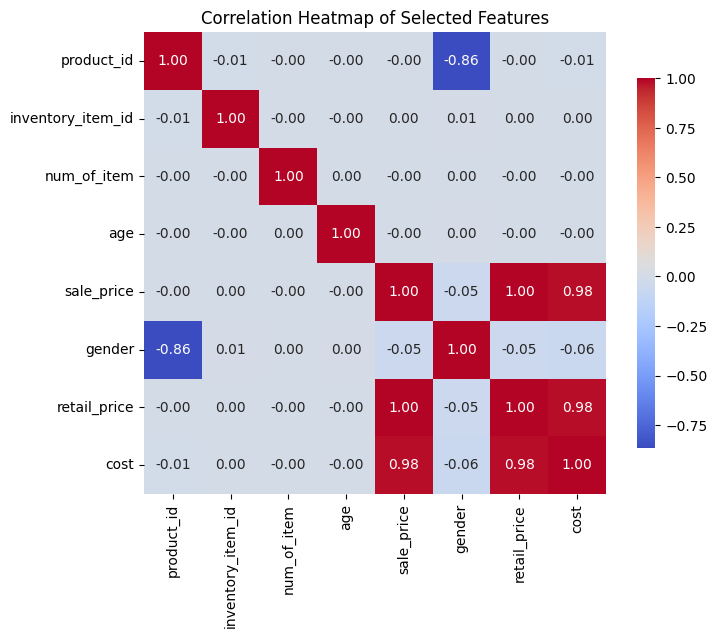

In [22]:
selected_columns = ['product_id','inventory_item_id','num_of_item', 
                    'age', 'sale_price','gender','retail_price','cost']
subset_df = master_df[selected_columns]

correlation_matrix = subset_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Draw the heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

# Set the title
plt.title('Correlation Heatmap of Selected Features')

# Show the plot
plt.show()

In [23]:
#Xóa cột cost vì có độ tương quan cao là 0.98
master_df = master_df.drop('cost',axis =1)
#Xóa cột sale_price vì có độ tương quan cao là 1
master_df = master_df.drop('sale_price',axis =1)

In [24]:
#xXây dựng thuộc tính mới là total_spend = retail_price * num_of_item
master_df['total_spend'] = master_df['retail_price'] * master_df['num_of_item']

## 3.3.3 Data Reduction/Dimension Reduction

In [25]:
master_df.info()
eda_df = master_df.copy()
temp = master_df.copy()

<class 'pandas.core.frame.DataFrame'>
Index: 179920 entries, 0 to 180077
Data columns (total 36 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   _id_x                   179920 non-null  object        
 1   order_id                179920 non-null  int64         
 2   user_id                 179920 non-null  int64         
 3   status                  179920 non-null  object        
 4   created_at              179920 non-null  datetime64[ns]
 5   num_of_item             179920 non-null  int64         
 6   shipped_at              179920 non-null  datetime64[ns]
 7   delivered_at            179920 non-null  datetime64[ns]
 8   returned_at             179920 non-null  datetime64[ns]
 9   _id_y                   179920 non-null  object        
 10  first_name              179920 non-null  object        
 11  last_name               179920 non-null  object        
 12  email                   179920 non-

In [26]:
#Feature Selection
temp=temp.drop(['first_name','last_name','email','state','street_address','postal_code','city','country','latitude','longitude','sku','department'],axis =1)

In [27]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 179920 entries, 0 to 180077
Data columns (total 24 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   _id_x                   179920 non-null  object        
 1   order_id                179920 non-null  int64         
 2   user_id                 179920 non-null  int64         
 3   status                  179920 non-null  object        
 4   created_at              179920 non-null  datetime64[ns]
 5   num_of_item             179920 non-null  int64         
 6   shipped_at              179920 non-null  datetime64[ns]
 7   delivered_at            179920 non-null  datetime64[ns]
 8   returned_at             179920 non-null  datetime64[ns]
 9   _id_y                   179920 non-null  object        
 10  age                     179920 non-null  int64         
 11  gender                  179920 non-null  int64         
 12  traffic_source          179920 non-

In [28]:
master_df = temp.copy()

## 3.3.4 Data discretization (Rời rạc hóa dữ liệu sẽ làm giảm đi các trường hợp của dữ liệu.)

In [29]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 179920 entries, 0 to 180077
Data columns (total 24 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   _id_x                   179920 non-null  object        
 1   order_id                179920 non-null  int64         
 2   user_id                 179920 non-null  int64         
 3   status                  179920 non-null  object        
 4   created_at              179920 non-null  datetime64[ns]
 5   num_of_item             179920 non-null  int64         
 6   shipped_at              179920 non-null  datetime64[ns]
 7   delivered_at            179920 non-null  datetime64[ns]
 8   returned_at             179920 non-null  datetime64[ns]
 9   _id_y                   179920 non-null  object        
 10  age                     179920 non-null  int64         
 11  gender                  179920 non-null  int64         
 12  traffic_source          179920 non-

In [30]:
master_df['age'].min()

12

In [31]:
master_df['age'].max()

70

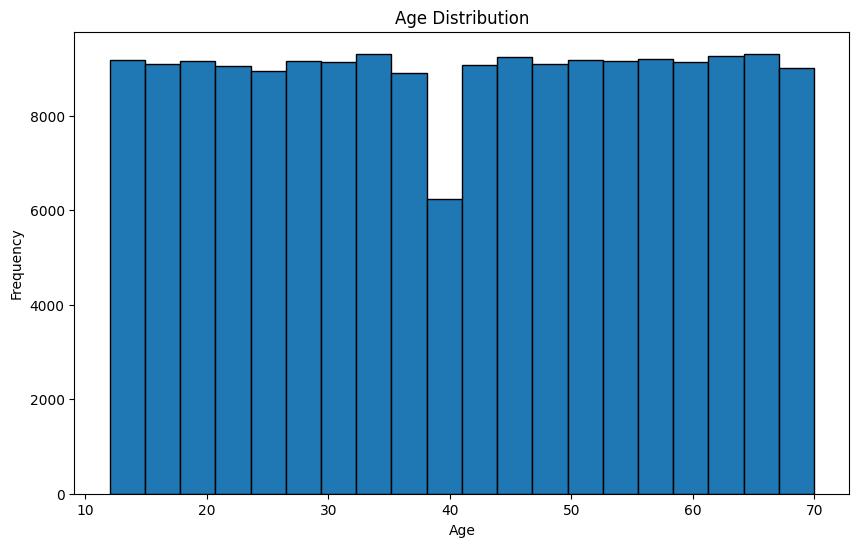

In [32]:
plt.figure(figsize=(10, 6))
plt.hist(master_df['age'], bins=20, edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
# plt.grid(axis='y', alpha=0.75)
plt.show()

In [33]:
#Sử dụng kỹ thuật binning 
bins = [0, 30, 50, 80]
labels = ['young', 'mid', 'old']
master_df['age_group'] = pd.cut(master_df['age'], bins=bins, labels=labels, right=False)

print(master_df[['age', 'age_group']].head(20))

    age age_group
0    52       old
1    52       old
2    52       old
3    56       old
4    40       mid
5    59       old
6    16     young
7    16     young
8    58       old
9    36       mid
10   61       old
11   61       old
12   44       mid
13   44       mid
14   44       mid
15   69       old
16   22     young
17   22     young
18   34       mid
19   34       mid


In [34]:
master_df['age_group']

0           old
1           old
2           old
3           old
4           mid
          ...  
180073      mid
180074      mid
180075      mid
180076    young
180077    young
Name: age_group, Length: 179920, dtype: category
Categories (3, object): ['young' < 'mid' < 'old']

In [35]:
master_df['total_spend'].min()

0.0199999995529651

In [36]:
master_df['total_spend'].max()

3996.0

In [37]:
total_spend_bins = [0, 100, 1000, 2000, 3000, 4000]
total_spend_labels = ['Very low', 'Low', 'Mid', 'High', 'Very high']

# Thực hiện Equal Width Binning cho cột 'total_spend'
master_df['total_spend_group'] = pd.cut(master_df['total_spend'], bins=total_spend_bins, labels=total_spend_labels, right=False)

print(master_df[['total_spend', 'total_spend_group']].head(20))

    total_spend total_spend_group
0     47.010000          Very low
1     74.969999          Very low
2     74.969999          Very low
3     16.990000          Very low
4     36.000000          Very low
5     49.990002          Very low
6     11.800000          Very low
7     74.580002          Very low
8     43.990002          Very low
9     52.000000          Very low
10    27.980000          Very low
11   144.000000               Low
12    75.000000          Very low
13    84.000000          Very low
14   294.000000               Low
15   209.000000               Low
16    63.840000          Very low
17    69.980003          Very low
18    66.000000          Very low
19    22.000000          Very low


In [38]:
master_df[ 'total_spend_group'].value_counts()

total_spend_group
Very low     119099
Low           60074
Mid             647
High             53
Very high        47
Name: count, dtype: int64

In [54]:
master_df.to_csv('Master2.csv',index=False)

In [3]:
sample_df = pd.read_csv('Master2.csv')

In [5]:
sample_df.tail(10)

,_id_x,order_id,user_id,status,created_at,num_of_item,shipped_at,delivered_at,returned_at,_id_y,...,_id,category,name,brand,retail_price,distribution_center_id,status_normalized,total_spend,age_group,total_spend_group
179910,6694c887d5842db88bb685b5,125196,99972,Shipped,2022-06-25 04:56:00,1,2022-06-28 01:24:00,1970-01-01,1970-01-01,6694ca71d5842db88bb8059c,...,6694c81dd5842db88bb47348,Tops & Tees,Geoffrey Beene Men's Regular Fit Herringbone D...,Geoffrey Beene,26.160000,6.0,4,26.160000,old,Very low
179911,6694c887d5842db88bb685b6,125199,99975,Shipped,2022-07-19 19:19:00,4,2022-07-22 04:08:00,1970-01-01,1970-01-01,6694ca6fd5842db88bb7704c,...,6694c81dd5842db88bb46b4d,Swim,Fox Men's Top Shelf Boardshort,Fox,49.500000,6.0,4,198.000000,old,Low
179912,6694c887d5842db88bb685b6,125199,99975,Shipped,2022-07-19 19:19:00,4,2022-07-22 04:08:00,1970-01-01,1970-01-01,6694ca6fd5842db88bb7704c,...,6694c81dd5842db88bb45234,Fashion Hoodies & Sweatshirts,Calvin Klein Sportswear Men's Long Sleeve Pont...,Calvin Klein,75.620003,3.0,4,302.480011,old,Low
179913,6694c887d5842db88bb685b6,125199,99975,Shipped,2022-07-19 19:19:00,4,2022-07-22 04:08:00,1970-01-01,1970-01-01,6694ca6fd5842db88bb7704c,...,6694c81ed5842db88bb48275,Pants,Nautica Men's Suit Separate Pant Brown,Nautica,79.989998,8.0,4,319.959991,old,Low
179914,6694c887d5842db88bb685b6,125199,99975,Shipped,2022-07-19 19:19:00,4,2022-07-22 04:08:00,1970-01-01,1970-01-01,6694ca6fd5842db88bb7704c,...,6694c81dd5842db88bb43cd1,Suits & Sport Coats,Afazzy Travel Blazer in Olive,Affazy,88.000000,2.0,4,352.000000,old,Low
179915,6694c887d5842db88bb685b7,125208,99983,Shipped,2022-03-14 08:06:00,1,2022-03-16 22:15:00,1970-01-01,1970-01-01,6694ca6cd5842db88bb6a776,...,6694c81dd5842db88bb4707f,Fashion Hoodies & Sweatshirts,ALPINESTARS Men's Phenomenal Fleece Hoodie,Alpinestars,79.949997,6.0,4,79.949997,mid,Very low
179916,6694c887d5842db88bb685b8,125210,99983,Shipped,2023-03-01 08:06:00,2,2023-03-02 03:50:00,1970-01-01,1970-01-01,6694ca6cd5842db88bb6a776,...,6694c81ed5842db88bb490ca,Fashion Hoodies & Sweatshirts,Billabong Men's Surfrider Foundation Full-Zip ...,Billabong,66.959999,9.0,4,133.919998,mid,Low
179917,6694c887d5842db88bb685b8,125210,99983,Shipped,2023-03-01 08:06:00,2,2023-03-02 03:50:00,1970-01-01,1970-01-01,6694ca6cd5842db88bb6a776,...,6694c81dd5842db88bb44c1d,Outerwear & Coats,Marmot Palisades Jacket - Men's,Marmot,300.000000,3.0,4,600.000000,mid,Low
179918,6694c887d5842db88bb685b9,125224,99999,Shipped,2023-12-22 04:29:00,2,2023-12-23 17:44:00,1970-01-01,1970-01-01,6694ca6fd5842db88bb7a93d,...,6694c81dd5842db88bb44b31,Underwear,Hanes Men's 3 Pack Comfortblend Long Leg Boxer...,Hanes,25.000000,3.0,4,50.000000,young,Very low
179919,6694c887d5842db88bb685b9,125224,99999,Shipped,2023-12-22 04:29:00,2,2023-12-23 17:44:00,1970-01-01,1970-01-01,6694ca6fd5842db88bb7a93d,...,6694c81dd5842db88bb478ad,Jeans,Wrangler Men's George Strait Cowboy Cut Jean,Wrangler,42.980000,7.0,4,85.959999,young,Very low


# 4.EDA

In [55]:
eda_df = pd.read_csv('Master2.csv')

## 4.1 Phân tích mô tả

In [56]:
eda_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179920 entries, 0 to 179919
Data columns (total 26 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   _id_x                   179920 non-null  object 
 1   order_id                179920 non-null  int64  
 2   user_id                 179920 non-null  int64  
 3   status                  179920 non-null  object 
 4   created_at              179920 non-null  object 
 5   num_of_item             179920 non-null  int64  
 6   shipped_at              179920 non-null  object 
 7   delivered_at            179920 non-null  object 
 8   returned_at             179920 non-null  object 
 9   _id_y                   179920 non-null  object 
 10  age                     179920 non-null  int64  
 11  gender                  179920 non-null  int64  
 12  traffic_source          179920 non-null  object 
 13  user_created_at         179920 non-null  object 
 14  product_id          

In [61]:
eda_df['gender'].value_counts()

gender
1    90054
0    89866
Name: count, dtype: int64

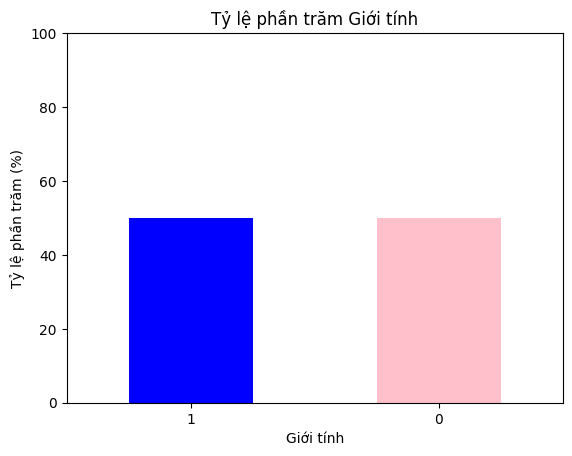

In [62]:
gender_counts = eda_df['gender'].value_counts(normalize=True) * 100

# Vẽ biểu đồ
gender_counts.plot(kind='bar', color=['blue', 'pink'])
plt.title('Tỷ lệ phần trăm Giới tính')
plt.xlabel('Giới tính')
plt.ylabel('Tỷ lệ phần trăm (%)')
plt.xticks(rotation=0)
plt.ylim(0,100)
plt.show()

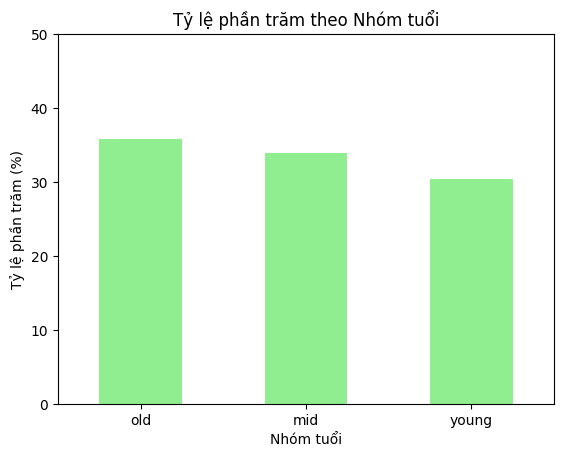

In [63]:
age_group_counts = eda_df['age_group'].value_counts(normalize=True) * 100

age_group_counts.plot(kind='bar', color='lightgreen')
plt.title('Tỷ lệ phần trăm theo Nhóm tuổi')
plt.xlabel('Nhóm tuổi')
plt.ylabel('Tỷ lệ phần trăm (%)')
plt.xticks(rotation=0)
plt.ylim(0,50)
plt.show()

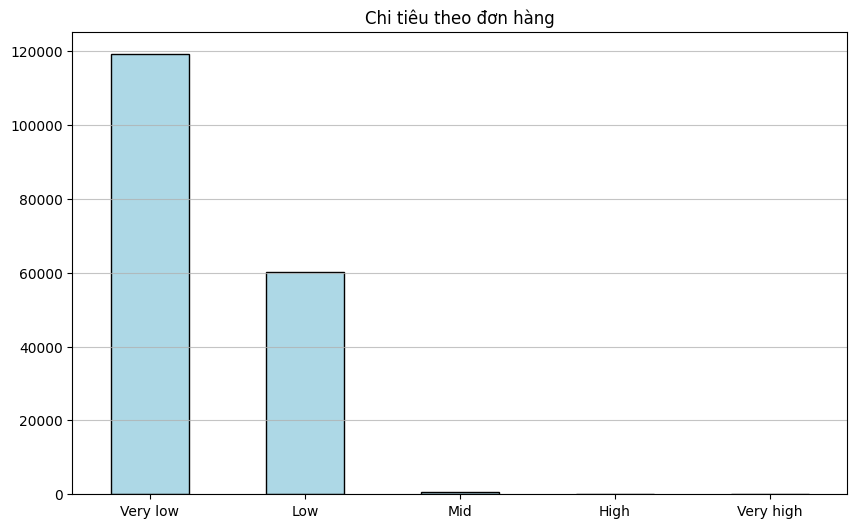

In [64]:
age_group_spending = eda_df['total_spend_group'].value_counts()

plt.figure(figsize=(10, 6))
age_group_spending.plot(kind='bar', color='lightblue', edgecolor='black')
plt.title('Chi tiêu theo đơn hàng')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.75)
plt.show()

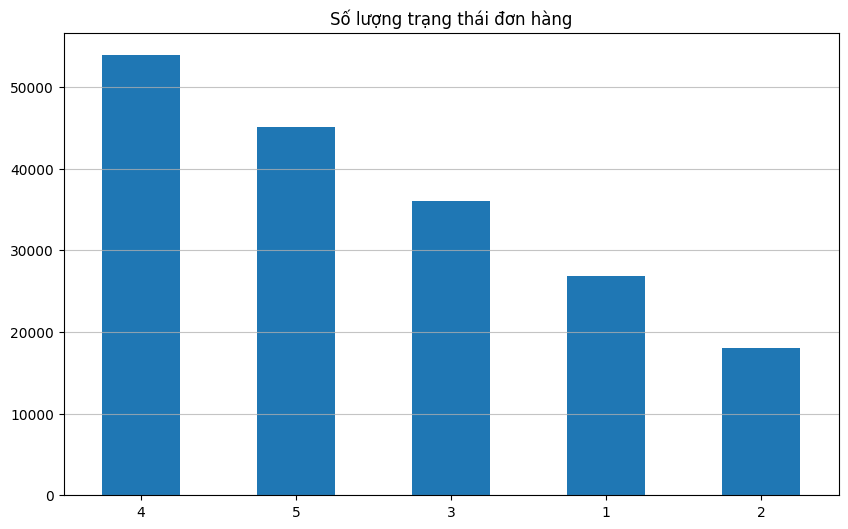

In [65]:
x = eda_df['status_normalized'].value_counts()

plt.figure(figsize=(10, 6))
x.plot(kind='bar')
plt.title('Số lượng trạng thái đơn hàng')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.75)
plt.show()

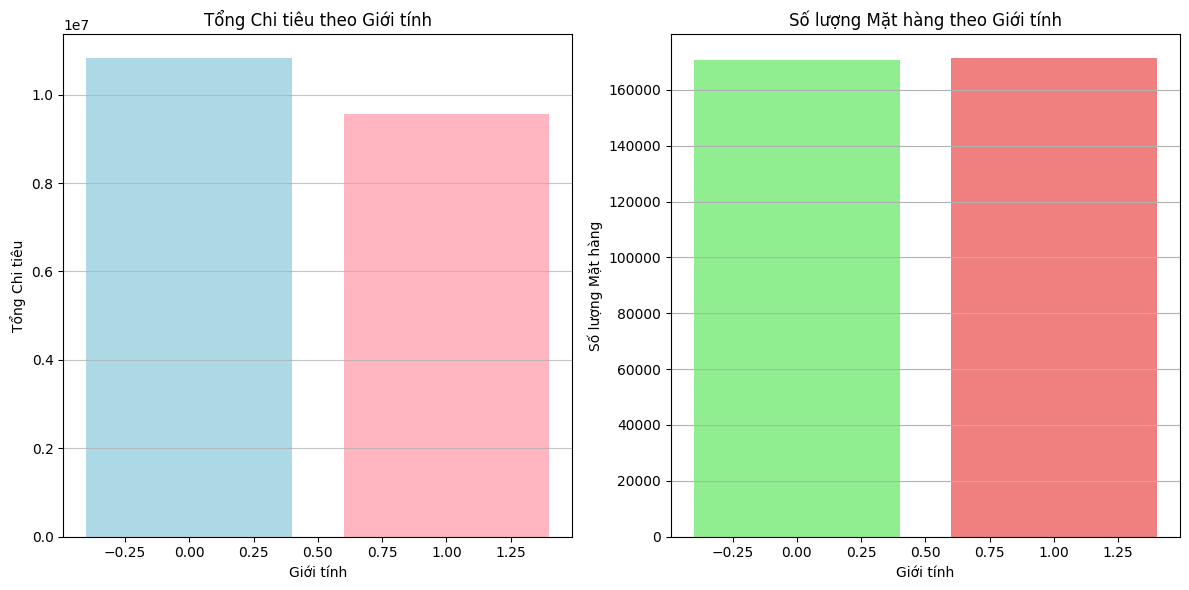

In [66]:
gender_summary = eda_df.groupby('gender').agg({'total_spend': 'sum', 'num_of_item': 'sum'}).reset_index()

plt.figure(figsize=(12, 6))

# Biểu đồ chi tiêu
plt.subplot(1, 2, 1)
plt.bar(gender_summary['gender'], gender_summary['total_spend'], color=['lightblue', 'lightpink'])
plt.title('Tổng Chi tiêu theo Giới tính')
plt.xlabel('Giới tính')
plt.ylabel('Tổng Chi tiêu')
plt.grid(axis='y', alpha=0.75)

plt.subplot(1, 2, 2)
plt.bar(gender_summary['gender'], gender_summary['num_of_item'], color=['lightgreen', 'lightcoral'])
plt.title('Số lượng Mặt hàng theo Giới tính')
plt.xlabel('Giới tính')
plt.ylabel('Số lượng Mặt hàng')
plt.grid(axis='y')

plt.tight_layout()
plt.show()

In [67]:
orders_per_user = eda_df.groupby('user_id')['order_id'].nunique().reset_index(name='order_count')

In [68]:
order_stats = orders_per_user['order_count'].describe()
print("\nThống kê về số lượng đơn hàng trên mỗi người dùng:")
print(order_stats)


Thống kê về số lượng đơn hàng trên mỗi người dùng:
count    79252.000000
mean         1.564604
std          0.862858
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          4.000000
Name: order_count, dtype: float64


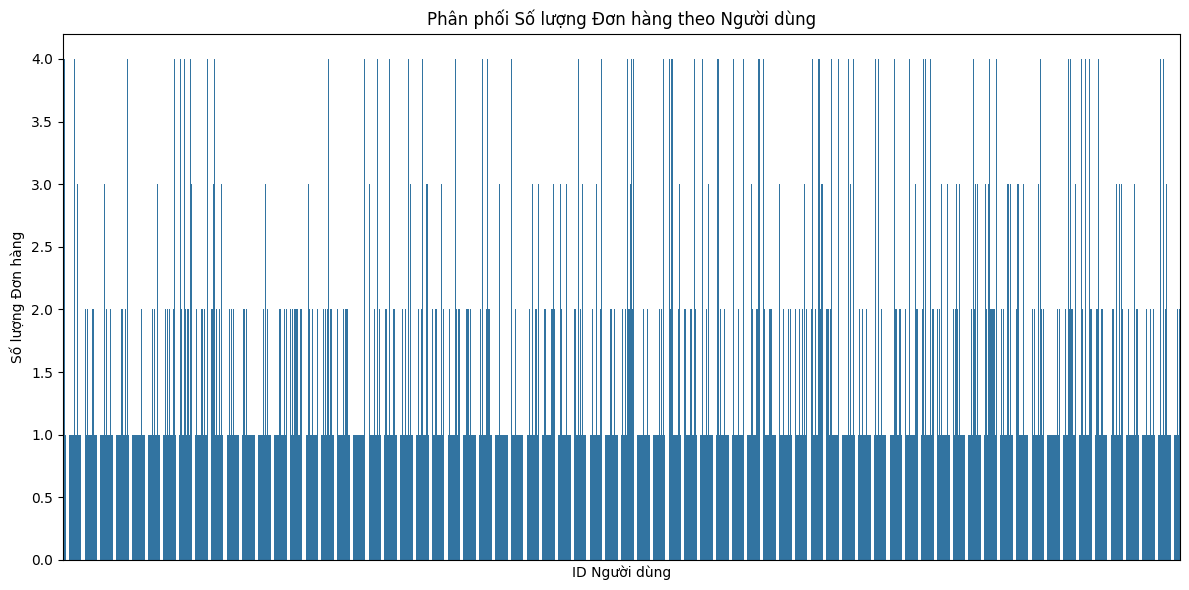

In [69]:
plt.figure(figsize=(12, 6))
orders_per_user_sorted = orders_per_user.sort_values('order_count')
sns.barplot(x='user_id', y='order_count', data=orders_per_user_sorted)
plt.title('Phân phối Số lượng Đơn hàng theo Người dùng')
plt.xlabel('ID Người dùng')
plt.ylabel('Số lượng Đơn hàng')
plt.xticks([])  # Ẩn nhãn trục x vì có quá nhiều người dùng
plt.tight_layout()
plt.show()

## 4.2 Phân tích dữ liệu

In [66]:
eda_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 179920 entries, 0 to 180077
Data columns (total 36 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   _id_x                   179920 non-null  object        
 1   order_id                179920 non-null  int64         
 2   user_id                 179920 non-null  int64         
 3   status                  179920 non-null  object        
 4   created_at              179920 non-null  datetime64[ns]
 5   num_of_item             179920 non-null  int64         
 6   shipped_at              179920 non-null  datetime64[ns]
 7   delivered_at            179920 non-null  datetime64[ns]
 8   returned_at             179920 non-null  datetime64[ns]
 9   _id_y                   179920 non-null  object        
 10  first_name              179920 non-null  object        
 11  last_name               179920 non-null  object        
 12  email                   179920 non-

### 1.Order by country

In [ ]:
country_order_counts = eda_df.groupby('country')['order_id'].count().reset_index()
country_order_counts = country_order_counts.sort_values(by='order_id', ascending=True)
country_order_counts

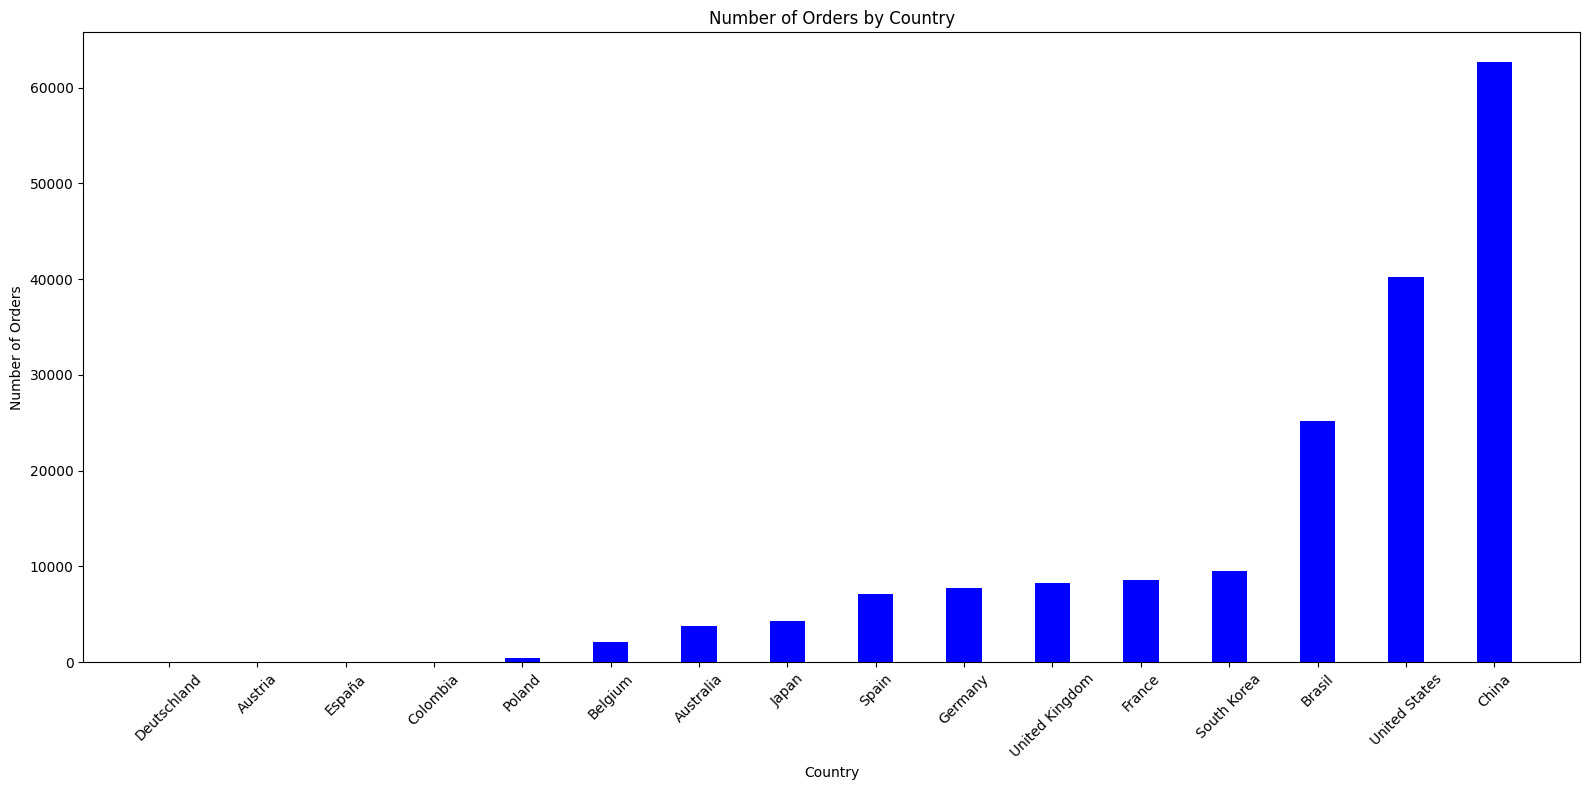

In [68]:
plt.figure(figsize=(16, 8))
plt.bar(country_order_counts['country'], country_order_counts['order_id'], color='blue', width=0.4)  
plt.xlabel('Country')  
plt.ylabel('Number of Orders')  
plt.title('Number of Orders by Country')  
plt.xticks(rotation=45)  
plt.tight_layout()  
plt.show()

In [73]:
spend_country_counts = eda_df.groupby('country')['total_spend'].sum().reset_index()
spend_country_counts = spend_country_counts.sort_values(by='total_spend', ascending=True)
spend_country_counts

,country,total_spend
1,Austria,8.449000e+01
6,Deutschland,1.499900e+02
7,España,1.659900e+02
5,Colombia,1.494500e+03
11,Poland,5.565381e+04
2,Belgium,2.336740e+05
0,Australia,4.129820e+05
10,Japan,5.108813e+05
13,Spain,8.407855e+05
9,Germany,8.712963e+05


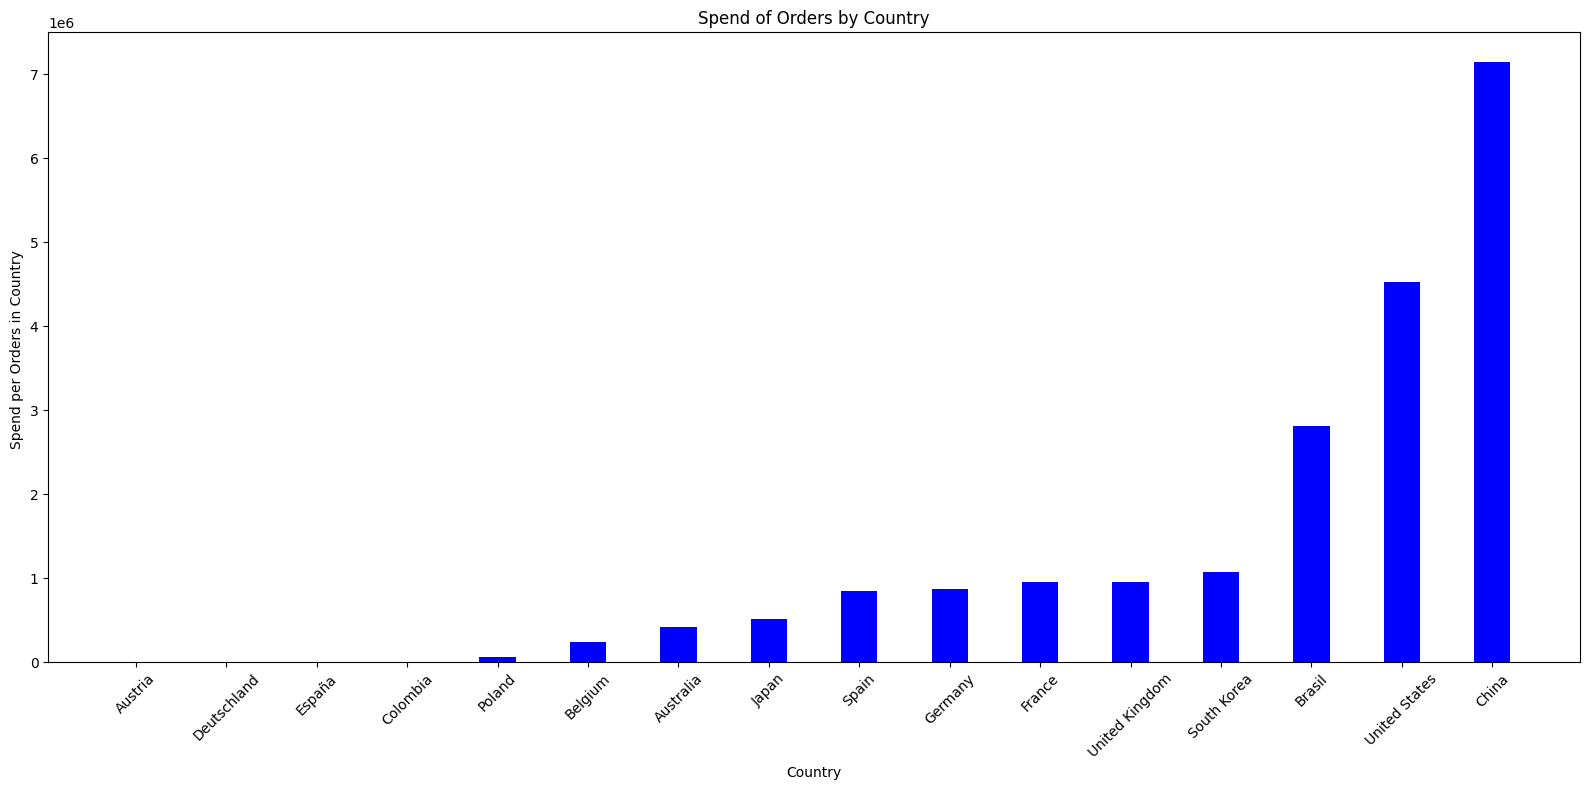

In [74]:
plt.figure(figsize=(16, 8))
plt.bar(spend_country_counts['country'], spend_country_counts['total_spend'], color='blue', width=0.4)  
plt.xlabel('Country')  
plt.ylabel('Spend per Orders in Country ')  
plt.title('Spend of Orders by Country')  
plt.xticks(rotation=45)  
plt.tight_layout()  
plt.show()

### 2.Order Status Distribution

In [145]:
status_order_counts = eda_df.groupby('status')['order_id'].count().reset_index()
status_order_counts = status_order_counts.sort_values(by='order_id', ascending=True)
status_order_counts

,status,order_id
3,Returned,18079
0,Cancelled,26798
2,Processing,36037
1,Complete,45131
4,Shipped,53875


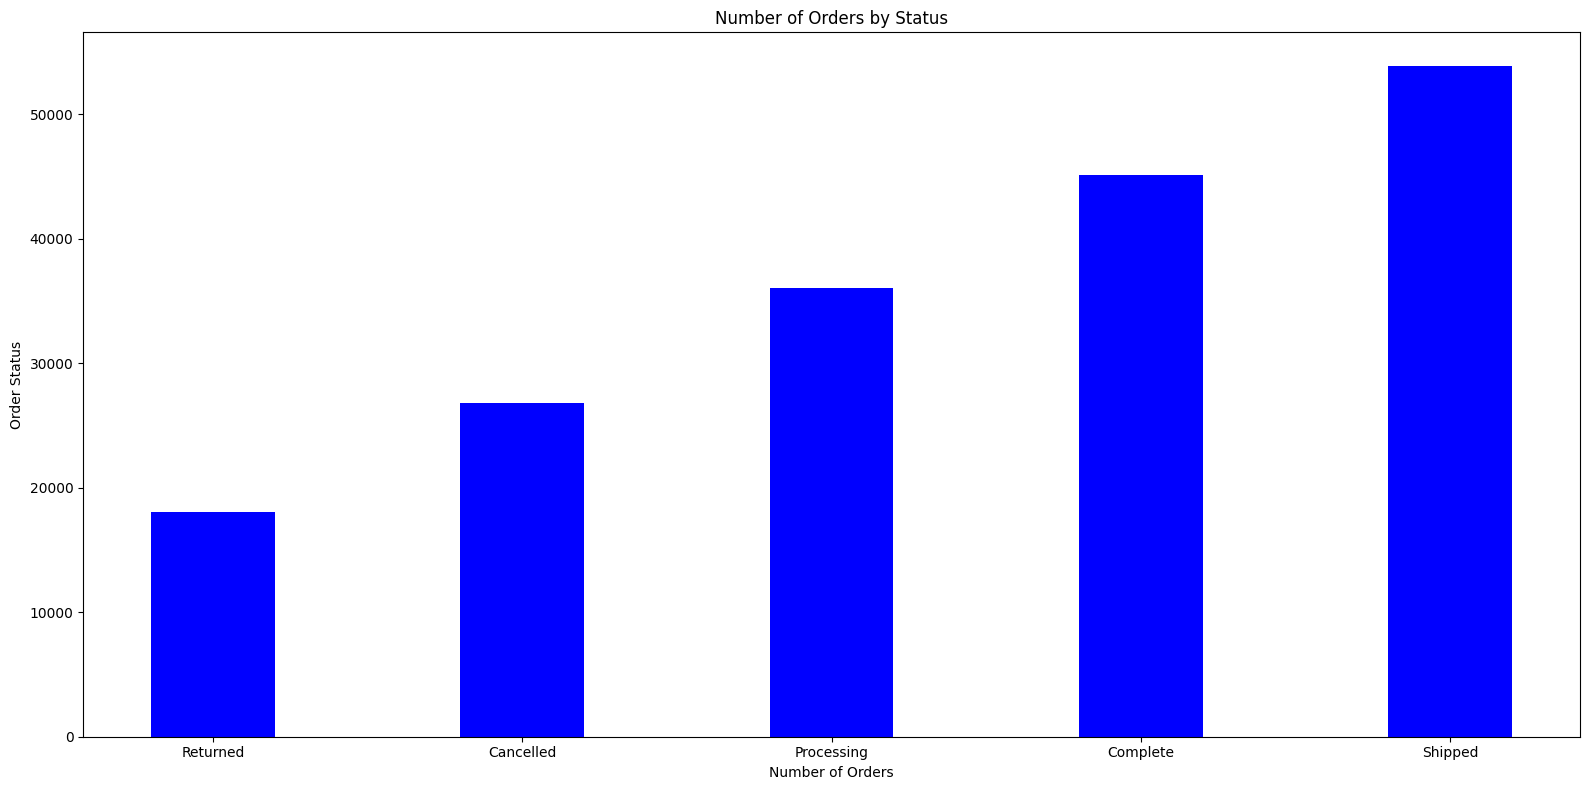

In [148]:
plt.figure(figsize=(16, 8))
plt.bar(status_order_counts['status'], status_order_counts['order_id'], color='blue', width=0.4)  
plt.xlabel('Number of Orders')  # X-axis label
plt.ylabel('Order Status')  # Y-axis label
plt.title('Number of Orders by Status')  # Title of the chart
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

### 3.Order by category

In [ ]:
category_order_counts = eda_df.groupby('category')['order_id'].count().reset_index()
category_order_counts = category_order_counts.sort_values(by='order_id', ascending=True)
category_order_counts

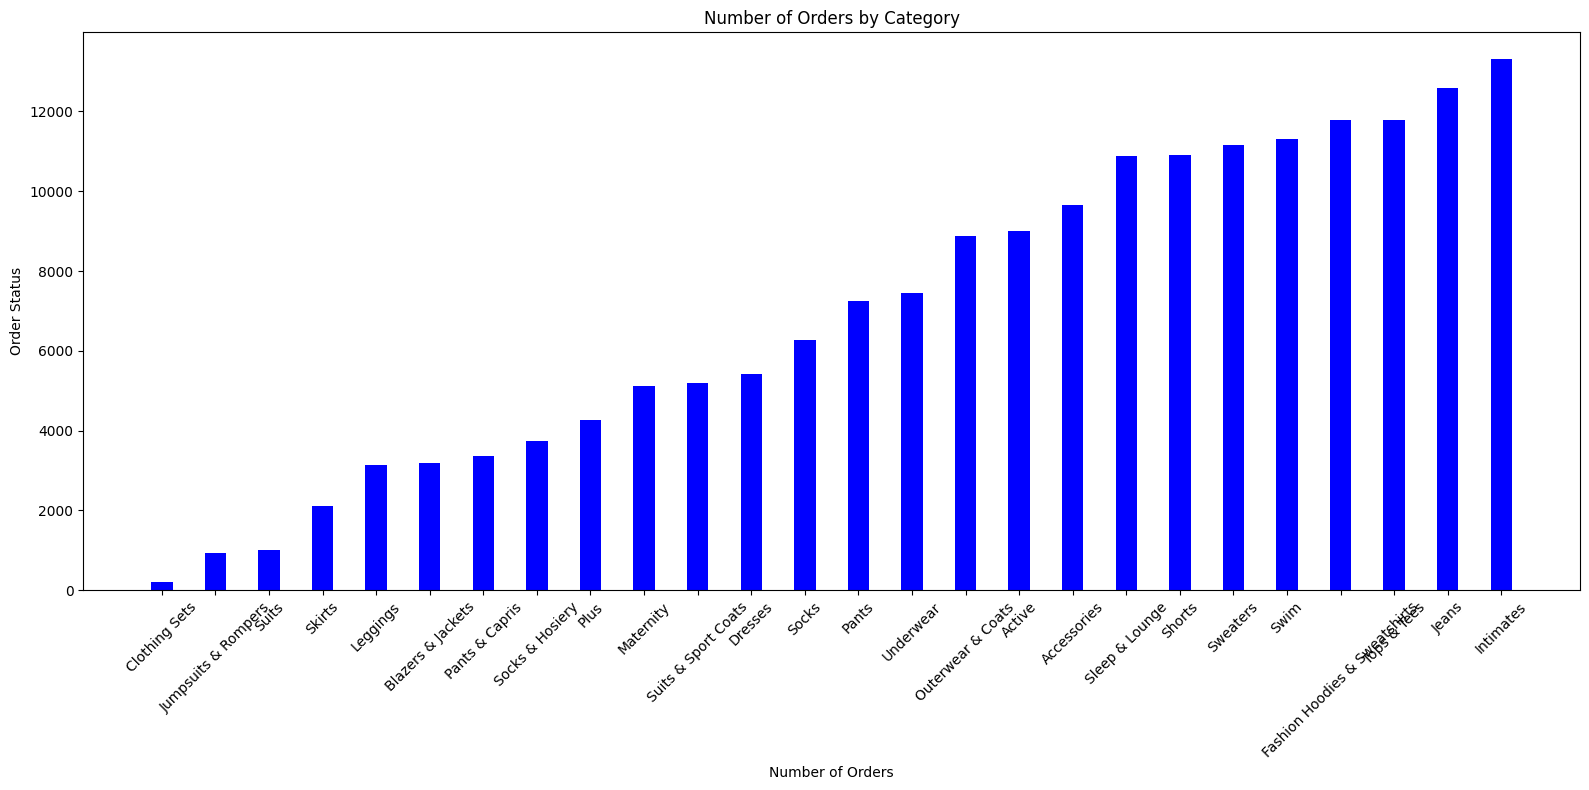

In [41]:
plt.figure(figsize=(16, 8))
plt.bar(category_order_counts['category'], category_order_counts['order_id'], color='blue', width=0.4)  
plt.xlabel('Number of Orders')  # X-axis label
plt.ylabel('Order Status')  # Y-axis label
plt.title('Number of Orders by Category')  # Title of the chart
plt.xticks(rotation=45) 
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

### 4.Orders by Age Group

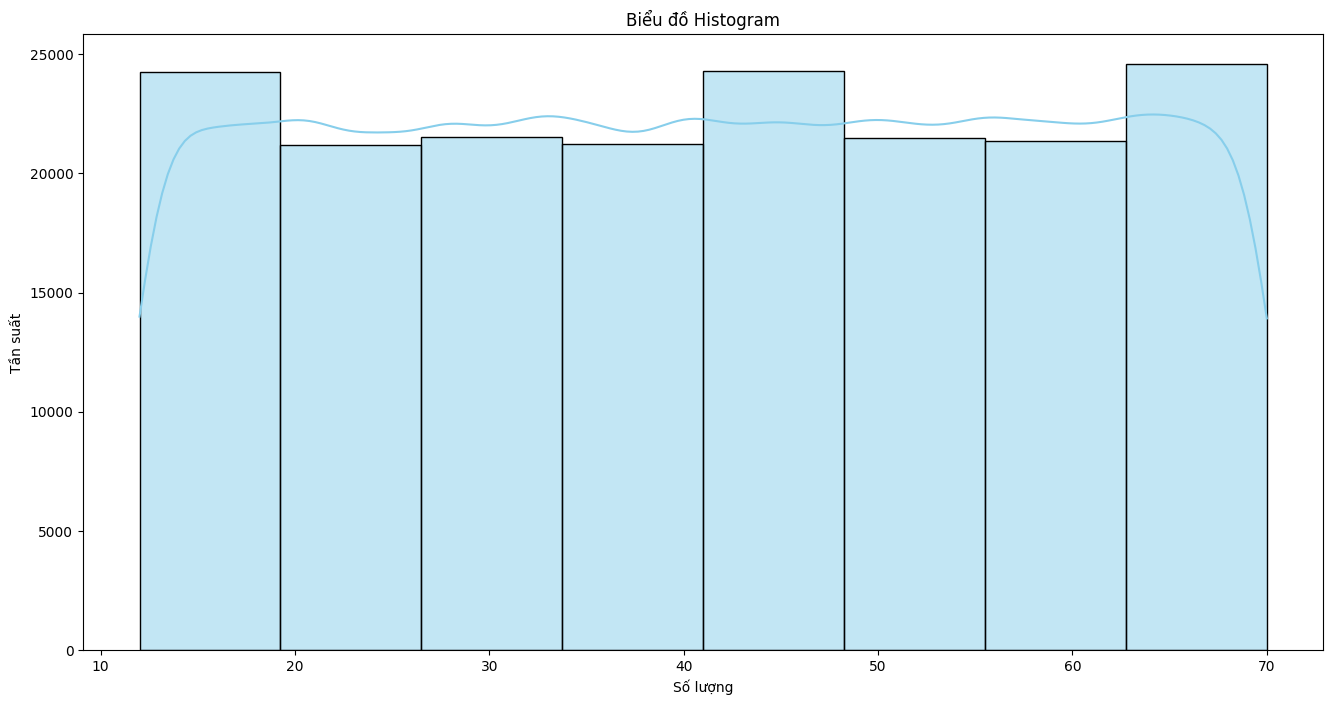

In [108]:
plt.figure(figsize=(16, 8))
# plt.hist(eda_df['age'], bins=8, color='skyblue', edgecolor='black')
sns.histplot(eda_df['age'], bins=8, kde=True, color='skyblue', edgecolor='black')
plt.xlabel('Số lượng')
plt.ylabel('Tần suất')
plt.title('Biểu đồ Histogram')
plt.show()

In [42]:
bins = [0, 20, 35, 55, 80]
labels = ['young', 'teen','mid', 'old']
eda_df['age_group'] = pd.cut(eda_df['age'], bins=bins, labels=labels, right=False)

print(eda_df[['age', 'age_group']].head(20))

    age age_group
0    52       mid
1    52       mid
2    52       mid
3    56       old
4    40       mid
5    59       old
6    16     young
7    16     young
8    58       old
9    36       mid
10   61       old
11   61       old
12   44       mid
13   44       mid
14   44       mid
15   69       old
16   22      teen
17   22      teen
18   34      teen
19   34      teen


In [43]:
age_order_counts = eda_df.groupby('age_group')['order_id'].count().reset_index()
age_order_counts = age_order_counts.sort_values(by='order_id', ascending=True)
age_order_counts

C:\Users\MSII\AppData\Local\Temp\ipykernel_10932\3833427136.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_order_counts = eda_df.groupby('age_group')['order_id'].count().reset_index()


,age_group,order_id
0,young,24232
1,teen,45717
3,old,49148
2,mid,60823


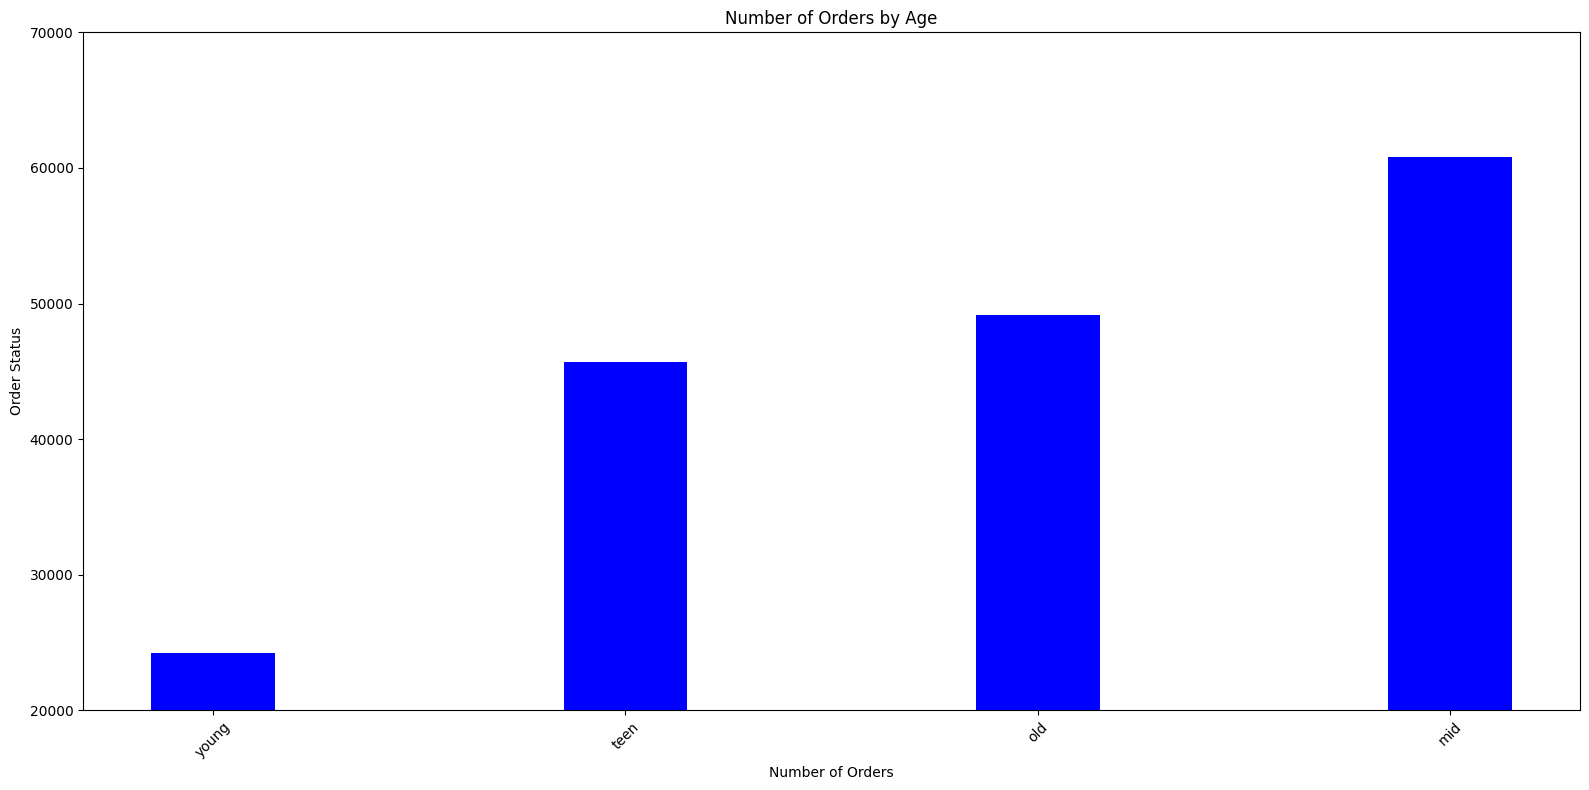

In [44]:
plt.figure(figsize=(16, 8))
plt.bar(age_order_counts['age_group'], age_order_counts['order_id'], color='blue', width=0.3)  
plt.xlabel('Number of Orders')  # X-axis label
plt.ylabel('Order Status')  # Y-axis label
plt.title('Number of Orders by Age')  # Title of the chart
plt.xticks(rotation=45) 
plt.ylim(20000, 70000)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

### 5.Sales by Category

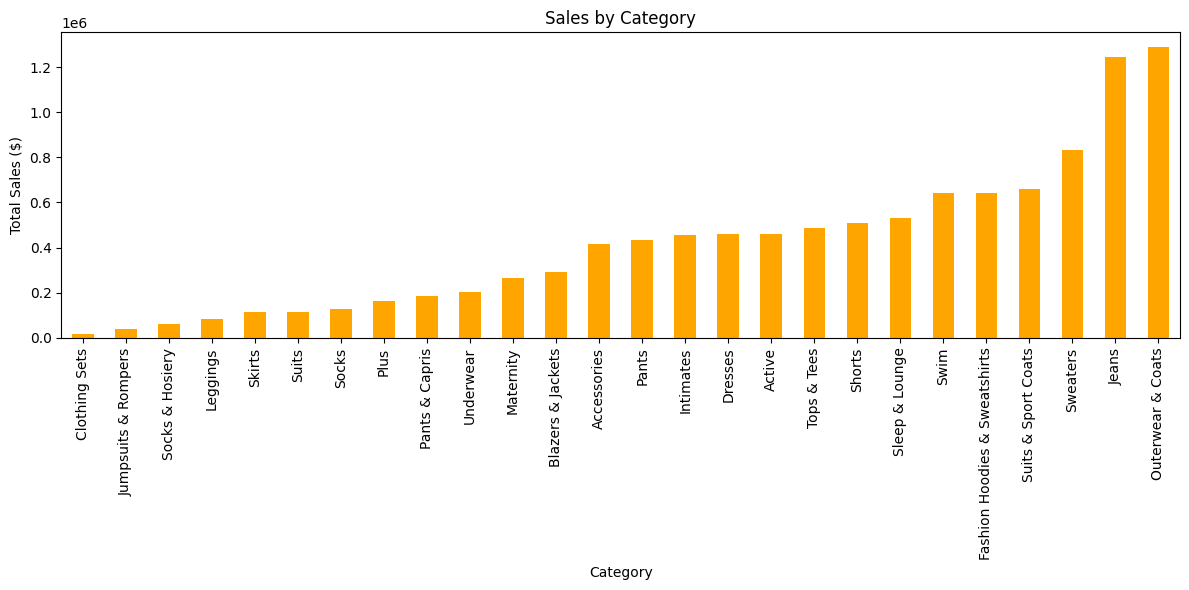

In [195]:
sales_by_category = eda_df.groupby('category')['retail_price'].sum().sort_values(ascending=True)

plt.figure(figsize=(12, 6))
sales_by_category.plot(kind='bar', color='orange')
plt.title('Sales by Category')
plt.xlabel('Category')
plt.ylabel('Total Sales ($)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### 6.Total Spend by User

In [227]:
total_spend_by_user = eda_df.groupby('user_id')['total_spend'].sum().reset_index()
total_spend_by_user = total_spend_by_user.sort_values(by='total_spend', ascending=True)
total_spend_by_user

,user_id,total_spend
12296,15553,0.490000
30301,38312,0.490000
55368,69897,1.500000
33061,41873,1.500000
30592,38681,1.510000
...,...,...
5481,6878,5184.239990
17142,21671,5250.280014
22438,28392,5365.959991
12450,15746,5406.799999


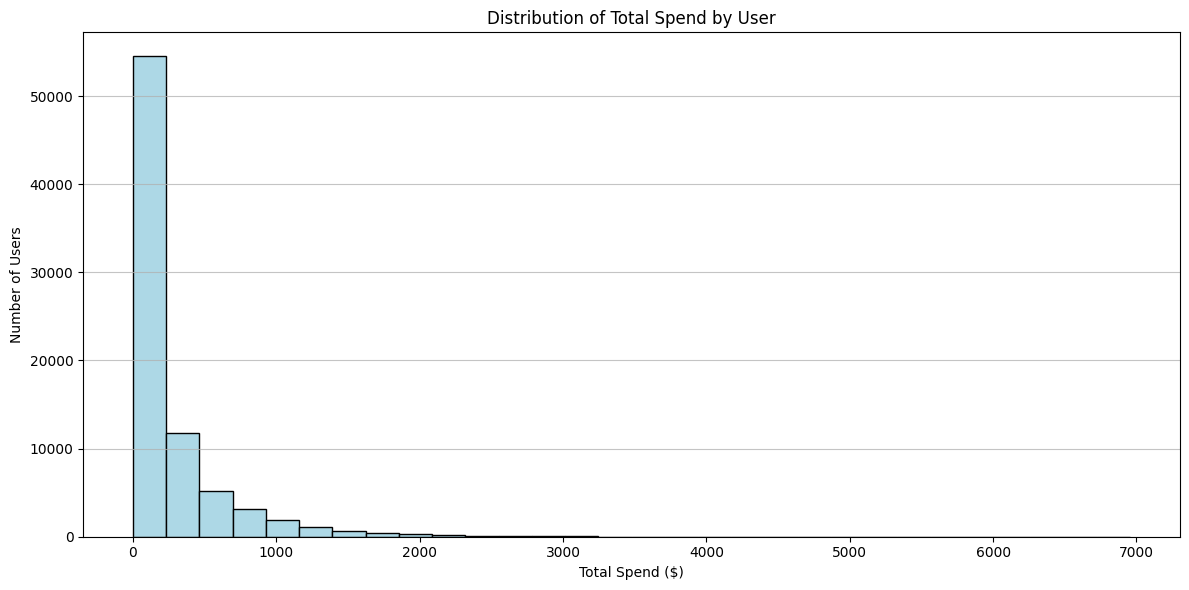

In [245]:
total_spend_by_user = eda_df.groupby('user_id')['total_spend'].sum()

plt.figure(figsize=(12, 6))
plt.hist(total_spend_by_user, bins=30, color='lightblue', edgecolor='black')
plt.title('Distribution of Total Spend by User')
plt.xlabel('Total Spend ($)')
plt.ylabel('Number of Users')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

### 7.Monthly Order Trends

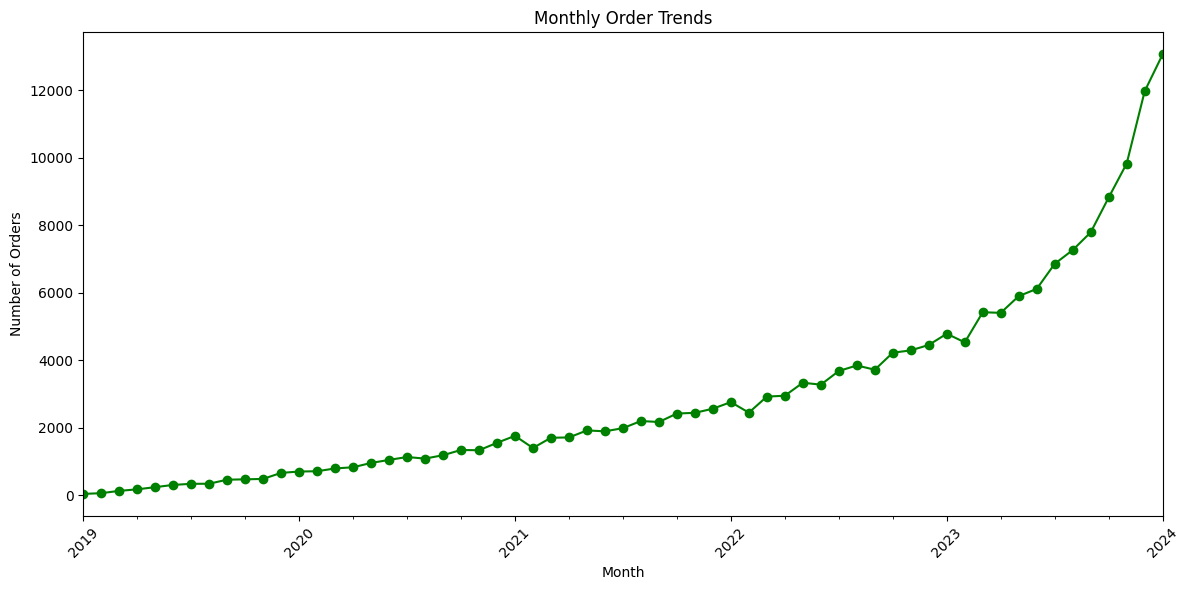

In [241]:
eda_df['created_at'] = pd.to_datetime(eda_df['created_at'])

# Extract month and year
eda_df['month_year'] = eda_df['created_at'].dt.to_period('M')

# Count orders per month
monthly_orders = eda_df.groupby('month_year').size()

plt.figure(figsize=(12, 6))
monthly_orders.plot(kind='line', marker='o', color='green')
plt.title('Monthly Order Trends')
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 8.Traffic Source Performance

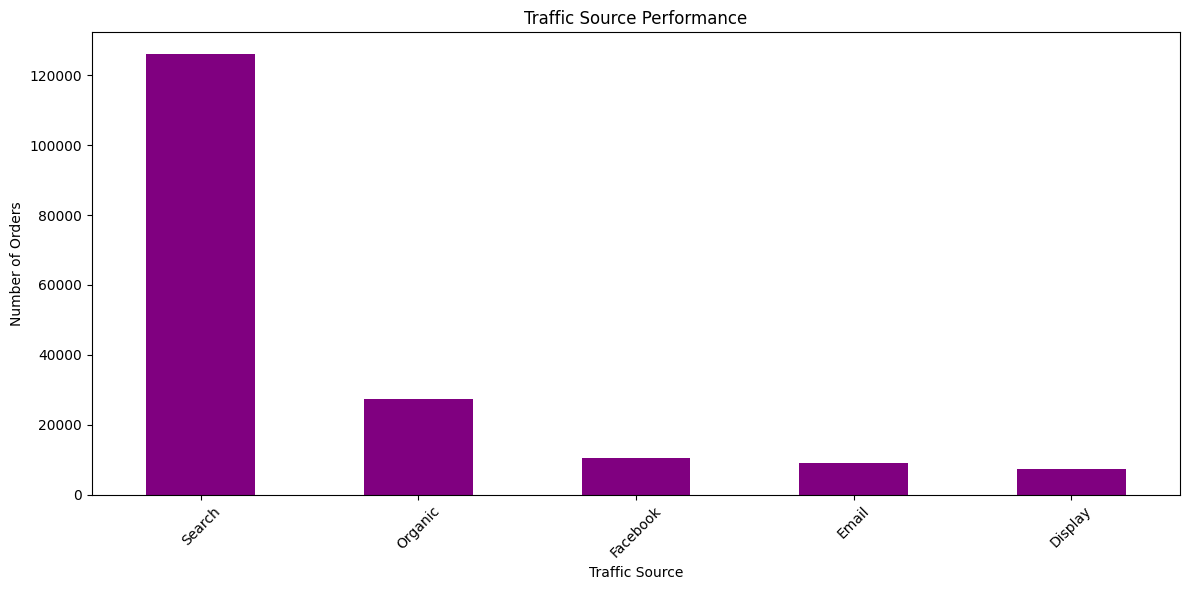

In [243]:
traffic_source_performance = eda_df['traffic_source'].value_counts()

plt.figure(figsize=(12, 6))
traffic_source_performance.plot(kind='bar', color='purple')
plt.title('Traffic Source Performance')
plt.xlabel('Traffic Source')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 5.Data Modeling

In [53]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 179920 entries, 0 to 180077
Data columns (total 26 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   _id_x                   179920 non-null  object        
 1   order_id                179920 non-null  int64         
 2   user_id                 179920 non-null  int64         
 3   status                  179920 non-null  object        
 4   created_at              179920 non-null  datetime64[ns]
 5   num_of_item             179920 non-null  int64         
 6   shipped_at              179920 non-null  datetime64[ns]
 7   delivered_at            179920 non-null  datetime64[ns]
 8   returned_at             179920 non-null  datetime64[ns]
 9   _id_y                   179920 non-null  object        
 10  age                     179920 non-null  int64         
 11  gender                  179920 non-null  int64         
 12  traffic_source          179920 non-

In [54]:
master_df = master_df.drop(['returned_at','shipped_at','delivered_at'],axis=1)

In [55]:
master_df = master_df[master_df['status_normalized'] != 1]

In [56]:
master_df['distribution_center_id'] = master_df['distribution_center_id'].astype('int32')

In [57]:
master_df['created_at'] = pd.to_datetime(master_df['created_at'])
master_df['user_created_at'] = pd.to_datetime(master_df['user_created_at'])

In [58]:
 master_df['total_spend_group'].unique()

['Low', 'Very low', 'Mid', 'Very high', 'High']
Categories (5, object): ['Very low' < 'Low' < 'Mid' < 'High' < 'Very high']

In [59]:
total_spend_group_mapping = {
    'Very low': 1,
    'Low': 2,
    'Mid': 3,
    'High': 4,
    'Very high': 5
}
# Create a new column with the normalized values
master_df['total_spend_group_normalized'] = master_df['total_spend_group'].map(total_spend_group_mapping)

In [60]:
master_df['total_spend_group_normalized']

13423     2
13424     1
13425     1
13426     1
13427     1
         ..
180073    1
180074    2
180075    2
180076    1
180077    1
Name: total_spend_group_normalized, Length: 153122, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

In [61]:
label_encoder = LabelEncoder()
master_df['label_category'] = label_encoder.fit_transform(master_df['category'])
master_df['label_brand'] = label_encoder.fit_transform(master_df['brand'])

In [62]:
numeric_columns = ['age', 'num_of_item', 'retail_price', 'total_spend_group_normalized','user_id','product_id']
scaler = StandardScaler()
scaled_features1 = scaler.fit_transform(master_df[numeric_columns])
master_df[numeric_columns] = scaler.fit_transform(master_df[numeric_columns])

In [63]:
numeric_columns2 = ['label_category','label_brand']
scaler2 = MinMaxScaler()
scaled_features2 = scaler2.fit_transform(master_df[numeric_columns2])
master_df[numeric_columns2] = scaler2.fit_transform(master_df[numeric_columns2])

In [64]:
master_df[['label_category','label_brand']]

,label_category,label_brand
13423,0.88,0.531636
13424,0.52,0.257818
13425,0.36,0.388000
13426,0.76,0.964364
13427,0.76,0.500727
...,...,...
180073,0.20,0.036727
180074,0.20,0.109091
180075,0.44,0.573455
180076,1.00,0.392727


In [65]:
scaled_features1

array([[-1.70456349, -0.84505701,  1.32062701,  1.34833966, -1.73326049,
        -1.68975462],
       [ 1.64028969, -0.84505701, -0.29413325, -0.70399205, -1.73256678,
        -1.20435678],
       [-0.41356752, -0.84505701, -0.23418337, -0.70399205, -1.73239335,
        -1.10963051],
       ...,
       [-0.06147771,  0.09453476,  3.5930422 ,  1.34833966,  1.7345571 ,
         1.06503262],
       [-1.64588185,  0.09453476, -0.51823527, -0.70399205,  1.73511207,
         1.2725509 ],
       [-1.64588185,  0.09453476, -0.24943248, -0.70399205,  1.73511207,
         0.66271341]])

In [66]:
master_df['num_of_item']

13423    -0.845057
13424    -0.845057
13425    -0.845057
13426    -0.845057
13427    -0.845057
            ...   
180073   -0.845057
180074    0.094535
180075    0.094535
180076    0.094535
180077    0.094535
Name: num_of_item, Length: 153122, dtype: float64

In [67]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 153122 entries, 13423 to 180077
Data columns (total 26 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   _id_x                         153122 non-null  object        
 1   order_id                      153122 non-null  int64         
 2   user_id                       153122 non-null  float64       
 3   status                        153122 non-null  object        
 4   created_at                    153122 non-null  datetime64[ns]
 5   num_of_item                   153122 non-null  float64       
 6   _id_y                         153122 non-null  object        
 7   age                           153122 non-null  float64       
 8   gender                        153122 non-null  int64         
 9   traffic_source                153122 non-null  object        
 10  user_created_at               153122 non-null  datetime64[ns]
 11  product_id    

In [68]:
# lưu tập dữ liệu
saved_df = master_df[['user_id','product_id','num_of_item','total_spend_group_normalized','label_category','label_brand']]
saved_df

,user_id,product_id,num_of_item,total_spend_group_normalized,label_category,label_brand
13423,-1.733260,-1.689755,-0.845057,1.348340,0.88,0.531636
13424,-1.732567,-1.204357,-0.845057,-0.703992,0.52,0.257818
13425,-1.732393,-1.109631,-0.845057,-0.703992,0.36,0.388000
13426,-1.732220,-0.703151,-0.845057,-0.703992,0.76,0.964364
13427,-1.731942,-0.753783,-0.845057,-0.703992,0.76,0.500727
...,...,...,...,...,...,...
180073,1.734557,0.287493,-0.845057,-0.703992,0.20,0.036727
180074,1.734557,0.268476,0.094535,1.348340,0.20,0.109091
180075,1.734557,1.065033,0.094535,1.348340,0.44,0.573455
180076,1.735112,1.272551,0.094535,-0.703992,1.00,0.392727


In [69]:
saved_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 153122 entries, 13423 to 180077
Data columns (total 6 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   user_id                       153122 non-null  float64
 1   product_id                    153122 non-null  float64
 2   num_of_item                   153122 non-null  float64
 3   total_spend_group_normalized  153122 non-null  float64
 4   label_category                153122 non-null  float64
 5   label_brand                   153122 non-null  float64
dtypes: float64(6)
memory usage: 8.2 MB


In [ ]:
saved_df.to_csv('Data.csv')

In [ ]:
master_df.head(10)

In [224]:
master_df.to_csv('Master3.csv')

# 6.Xây dựng mô hình dự đoán

## K-Means test

In [86]:
kmeans_features1 = ['age', 'num_of_item', 'total_spend', 'traffic_source', 'category', 'brand', 'gender']

In [98]:
# Tạo pipeline cho tiền xử lý và PCA
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['age', 'num_of_item', 'total_spend']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['traffic_source', 'category', 'brand', 'gender'])
    ])
pca_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=5))  # Giữ lại 95% phương sai
])

In [87]:
X1 = preprocessor.fit_transform(master_df[kmeans_features1])

In [89]:
X_train1, X_test1 = train_test_split(X1, test_size=0.2, random_state=42)

In [90]:
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
kmeans.fit(X_train1)

KMeans(n_clusters=5, n_init=10, random_state=42)

In [92]:
silhouette_avg = silhouette_score(X_train1, kmeans.labels_)
print(f"Silhouette Score for K-Means: {silhouette_avg}")

Silhouette Score for K-Means: 0.12009360992821284


## Matrix Factorization(SVD)

In [119]:
reader = Reader(rating_scale=(master_df['num_of_item'].min(), master_df['num_of_item'].max()))
data = Dataset.load_from_df(master_df[['user_id', 'product_id', 'num_of_item']], reader)

In [120]:
trainset, testset = surprise_split(data, test_size=0.2, random_state=42)

In [121]:
svd = SVD(n_factors=100, n_epochs=20, lr_all=0.005, reg_all=0.02)
svd.fit(trainset)

In [122]:
predictions_svd = svd.test(testset)
rmse_svd = accuracy.rmse(predictions_svd)
mae_svd = accuracy.mae(predictions_svd)
print(f"RMSE for SVD: {rmse_svd}")
print(f"MAE for SVD: {mae_svd}")

RMSE: 0.9803
MAE:  0.8299
RMSE for SVD: 0.9802704034550124
MAE for SVD: 0.8299012955019507


In [ ]:
# Collaborative Filtering

In [93]:
kmeans_features2 = ['age', 'num_of_item', 'total_spend', 'traffic_source', 'category', 'brand', 'gender']

In [99]:
X_pca = pca_pipeline.fit_transform(master_df[kmeans_features2])

In [100]:
print(f"Số lượng đặc trưng sau PCA: {X_pca.shape[1]}")

Số lượng đặc trưng sau PCA: 5


In [158]:
X_train2, X_test2 = train_test_split(X1, test_size=0.2, random_state=42)

In [ ]:
trainset_df = pd.DataFrame(trainset)
train_sample = trainset_df.sample(n=30000, random_state=42)

In [ ]:
cf_user = KNNBasic(sim_options={'name': 'cosine', 'user_based': True})
cf_user.fit(trainset)

## Test

In [85]:
def evaluate_model(model, trainset, testset):
    model.fit(trainset)
    predictions = model.test(testset)
    rmse = accuracy.rmse(predictions)
    return rmse

In [83]:
reader = Reader(rating_scale=(master_df['num_of_item'].min(), master_df['num_of_item'].max()))
data = Dataset.load_from_df(master_df[['user_id', 'product_id', 'num_of_item']], reader)

trainset, testset = surprise_split(data, test_size=0.3, random_state=42)

In [87]:
reader = Reader(rating_scale=(master_df['total_spend_group_normalized'].min(), master_df['total_spend_group_normalized'].max()))
data2 = Dataset.load_from_df(master_df[['user_id', 'product_id', 'total_spend_group_normalized']], reader)

trainset2, testset2 = surprise_split(data2, test_size=0.3, random_state=42)

In [89]:
reader = Reader(rating_scale=(master_df['label_category'].min(), master_df['label_category'].max()))
data3 = Dataset.load_from_df(master_df[['user_id', 'product_id', 'label_category']], reader)

trainset3, testset3 = surprise_split(data3, test_size=0.3, random_state=42)

In [95]:
reader = Reader(rating_scale=(master_df['retail_price'].min(), master_df['retail_price'].max()))
data4 = Dataset.load_from_df(master_df[['user_id', 'product_id', 'retail_price']], reader)

trainset4, testset4 = surprise_split(data4, test_size=0.3, random_state=42)

## Train model

In [86]:
svd_model = SVD(n_factors=100, n_epochs=100, lr_all=0.005, reg_all=0.02)
svd_rmse = evaluate_model(svd_model, trainset, testset)

RMSE: 0.8628


In [88]:
svd_model2 = SVD(n_factors=100, n_epochs=100, lr_all=0.005, reg_all=0.02)
svd_rmse2 = evaluate_model(svd_model2, trainset2, testset2)

RMSE: 0.8114


In [91]:
svd_model3 = SVD(n_factors=100, n_epochs=100, lr_all=0.005, reg_all=0.02)
svd_rmse3 = evaluate_model(svd_model3, trainset3, testset3)

RMSE: 0.1883


In [96]:
svd_model4 = SVD(n_factors=100, n_epochs=100, lr_all=0.005, reg_all=0.02)
svd_rmse4 = evaluate_model(svd_model4, trainset4, testset4)

RMSE: 0.6229


In [228]:
sample_size = 50000  # hoặc một số phù hợp với bộ nhớ của bạn
sampled_df = master_df.sample(n=sample_size, random_state=42)

reader = Reader(rating_scale=(sampled_df['num_of_item'].min(), sampled_df['num_of_item'].max()))
data = Dataset.load_from_df(sampled_df[['user_id', 'product_id', 'num_of_item']], reader)
trainset_min, testset_min = surprise_split(data, test_size=0.3, random_state=42)

In [230]:
knn_model = KNNBasic(k=25, min_k=1, sim_options={'name': 'pearson_baseline', 'user_based': False})
knn_rmse = evaluate_model(knn_model, trainset_min, testset_min)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.0701


In [ ]:
knn_model2 = KNNBasic(k=25, min_k=1, sim_options={'name': 'pearson_baseline', 'user_based': False})
knn_rmse2 = evaluate_model(knn_model2, trainset2, testset2)

In [131]:
knn_model3 = KNNBasic(k=25, min_k=1, sim_options={'name': 'pearson_baseline', 'user_based': False})
knn_rmse3 = evaluate_model(knn_model3, trainset3, testset3)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 7.9449


# 7.Final Model

In [47]:
def evaluate_model(model, trainset, testset):
    model.fit(trainset)
    predictions = model.test(testset)
    rmse = accuracy.rmse(predictions)
    return rmse

## Chia tập dữ liệu cho svd

In [248]:
reader = Reader(rating_scale=(master_df['num_of_item'].min(), master_df['num_of_item'].max()))
data1 = Dataset.load_from_df(master_df[['user_id', 'product_id', 'num_of_item']], reader)

trainset1, testset1 = surprise_split(data1, test_size=0.3, random_state=42)

In [77]:
reader = Reader(rating_scale=(master_df['total_spend_group_normalized'].min(), master_df['total_spend_group_normalized'].max()))
data2 = Dataset.load_from_df(master_df[['user_id', 'product_id', 'total_spend_group_normalized']], reader)

trainset2, testset2 = surprise_split(data2, test_size=0.3, random_state=42)

In [78]:
reader = Reader(rating_scale=(master_df['age'].min(), master_df['age'].max()))
data3 = Dataset.load_from_df(master_df[['user_id', 'product_id', 'age']], reader)

trainset3, testset3 = surprise_split(data3, test_size=0.3, random_state=42)

In [79]:
reader = Reader(rating_scale=(master_df['retail_price'].min(), master_df['retail_price'].max()))
data4 = Dataset.load_from_df(master_df[['user_id', 'product_id', 'retail_price']], reader)

trainset4, testset4 = surprise_split(data4, test_size=0.3, random_state=42)

In [80]:
reader = Reader(rating_scale=(master_df['label_brand'].min(), master_df['label_brand'].max()))
data5 = Dataset.load_from_df(master_df[['user_id', 'product_id', 'label_brand']], reader)

trainset5, testset5 = surprise_split(data5, test_size=0.3, random_state=42)

In [81]:
reader = Reader(rating_scale=(master_df['label_category'].min(), master_df['label_category'].max()))
data6 = Dataset.load_from_df(master_df[['user_id', 'product_id', 'label_category']], reader)

trainset6, testset6 = surprise_split(data6, test_size=0.3, random_state=42)

## Chia tập dữ liệu cho KNN

In [49]:
sample_size = 50000  # hoặc một số phù hợp với bộ nhớ của bạn
sampled_df = master_df.sample(n=sample_size, random_state=42)

reader = Reader(rating_scale=(sampled_df['num_of_item'].min(), sampled_df['num_of_item'].max()))
data_knn1 = Dataset.load_from_df(sampled_df[['user_id', 'product_id', 'num_of_item']], reader)
trainset_min1, testset_min1 = surprise_split(data_knn1, test_size=0.3, random_state=42)

In [78]:
sample_size = 50000  # hoặc một số phù hợp với bộ nhớ của bạn
sampled_df = master_df.sample(n=sample_size, random_state=42)

reader = Reader(rating_scale=(sampled_df['total_spend_group_normalized'].min(), sampled_df['total_spend_group_normalized'].max()))
data_knn2 = Dataset.load_from_df(sampled_df[['user_id', 'product_id', 'total_spend_group_normalized']], reader)
trainset_min2, testset_min2 = surprise_split(data_knn2, test_size=0.3, random_state=42)

In [85]:
sample_size = 50000  # hoặc một số phù hợp với bộ nhớ của bạn
sampled_df = master_df.sample(n=sample_size, random_state=42)

reader = Reader(rating_scale=(sampled_df['age'].min(), sampled_df['age'].max()))
data_knn3 = Dataset.load_from_df(sampled_df[['user_id', 'product_id', 'age']], reader)
trainset_min3, testset_min3 = surprise_split(data_knn3, test_size=0.3, random_state=42)

In [86]:
sample_size = 50000  # hoặc một số phù hợp với bộ nhớ của bạn
sampled_df = master_df.sample(n=sample_size, random_state=42)

reader = Reader(rating_scale=(sampled_df['retail_price'].min(), sampled_df['retail_price'].max()))
data_knn4 = Dataset.load_from_df(sampled_df[['user_id', 'product_id', 'retail_price']], reader)
trainset_min4, testset_min4 = surprise_split(data_knn4, test_size=0.3, random_state=42)

In [87]:
sample_size = 50000  # hoặc một số phù hợp với bộ nhớ của bạn
sampled_df = master_df.sample(n=sample_size, random_state=42)

reader = Reader(rating_scale=(sampled_df['label_brand'].min(), sampled_df['label_brand'].max()))
data_knn5 = Dataset.load_from_df(sampled_df[['user_id', 'product_id', 'label_brand']], reader)
trainset_min5, testset_min5 = surprise_split(data_knn5, test_size=0.3, random_state=42)

In [88]:
sample_size = 50000  # hoặc một số phù hợp với bộ nhớ của bạn
sampled_df = master_df.sample(n=sample_size, random_state=42)

reader = Reader(rating_scale=(sampled_df['label_category'].min(), sampled_df['label_category'].max()))
data_knn6 = Dataset.load_from_df(sampled_df[['user_id', 'product_id', 'label_category']], reader)
trainset_min6, testset_min6 = surprise_split(data_knn1, test_size=0.3, random_state=42)

## Train model

### SVD

In [75]:
svd_model = SVD(n_factors=100, n_epochs=100, lr_all=0.005, reg_all=0.02)

In [250]:
#num_of_item
svd_rmse1 = evaluate_model(svd_model, trainset1, testset1)

RMSE: 0.8639


In [89]:
#total_spend_group_normalized
svd_rmse2 = evaluate_model(svd_model, trainset2, testset2)

RMSE: 0.8104


In [90]:
#age
svd_rmse3 = evaluate_model(svd_model, trainset3, testset3)

RMSE: 0.8092


In [91]:
#retail_price
svd_rmse4 = evaluate_model(svd_model, trainset4, testset4)

RMSE: 0.6215


In [92]:
#label_brand
svd_rmse5 = evaluate_model(svd_model, trainset5, testset5)

RMSE: 0.1794


In [93]:
#label_category
svd_rmse6 = evaluate_model(svd_model, trainset6, testset6)

RMSE: 0.1868


### KNN

In [45]:
knn_model = KNNBasic(k=10, min_k=1, sim_options={'name': 'pearson_baseline', 'user_based': False})

In [50]:
#num_of_item
knn_rmse1 = evaluate_model(knn_model, trainset_min1, testset_min1)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.0717


In [79]:
#total_spend_group_normalized
knn_rmse2 = evaluate_model(knn_model, trainset_min2, testset_min2)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9975


In [92]:
#age
knn_rmse3 = evaluate_model(knn_model, trainset_min3, testset_min3)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.0012


In [95]:
#retail_price
knn_rmse4 = evaluate_model(knn_model, trainset_min4, testset_min4)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9678


In [100]:
#label_brand
knn_rmse5 = evaluate_model(knn_model, trainset_min5, testset_min5)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.2939


In [103]:
#label_category
knn_rmse6 = evaluate_model(knn_model, trainset_min6, testset_min6)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.0055


# 8.Chạy mô hình dự đoán

## test1

In [74]:
def recommend_items(user_id, product_id, model, n=10):
    # Get all items the user hasn't interacted with
    user_items = master_df[master_df['user_id'] == user_id]['product_id'].values
    all_items = master_df['product_id'].unique()
    items_to_predict = np.setdiff1d(all_items, user_items)

    # Make predictions
    predictions = [model.predict(user_id, item) for item in items_to_predict]

    # Sort predictions and get top N
    top_n = sorted(predictions, key=lambda x: x.est, reverse=True)[:n]

    return top_n

In [75]:
#user_id = master_df['user_id'].iloc[100]  # Example user
user_id = 287
product_id = master_df['product_id'].iloc[0]  # Example product
recommendations = recommend_items(user_id, product_id, svd_model)

In [76]:
recommendations

[Prediction(uid=287, iid=27495, r_ui=None, est=2.6512615069885106, details={'was_impossible': False}),
 Prediction(uid=287, iid=29009, r_ui=None, est=2.5973666566772287, details={'was_impossible': False}),
 Prediction(uid=287, iid=22682, r_ui=None, est=2.5787969989900015, details={'was_impossible': False}),
 Prediction(uid=287, iid=15905, r_ui=None, est=2.5643126535698344, details={'was_impossible': False}),
 Prediction(uid=287, iid=17314, r_ui=None, est=2.5490626898692463, details={'was_impossible': False}),
 Prediction(uid=287, iid=19359, r_ui=None, est=2.547300061325927, details={'was_impossible': False}),
 Prediction(uid=287, iid=28081, r_ui=None, est=2.540242007351142, details={'was_impossible': False}),
 Prediction(uid=287, iid=308, r_ui=None, est=2.537478390618186, details={'was_impossible': False}),
 Prediction(uid=287, iid=621, r_ui=None, est=2.53496643089347, details={'was_impossible': False}),
 Prediction(uid=287, iid=25301, r_ui=None, est=2.5323452614730178, details={'was_i

## test2

In [81]:
def recommend_items2(user_id, input_products, model, n=10):
    # Get all items the user hasn't interacted with
    user_items = master_df[master_df['user_id'] == user_id]['product_id'].values
    all_items = master_df['product_id'].unique()
    items_to_predict = np.setdiff1d(all_items, user_items)
    
    # Make predictions
    predictions = [model.predict(user_id, item) for item in items_to_predict]
    
    # Adjust predictions based on input products
    for product in input_products:
        if product in items_to_predict:
            # Increase the estimated rating for input products
            idx = np.where(items_to_predict == product)[0][0]
            predictions[idx] = predictions[idx]._replace(est=predictions[idx].est * 1.2)  # Increase by 20%
    
    # Sort predictions and get top N
    top_n = sorted(predictions, key=lambda x: x.est, reverse=True)[:n]
    return top_n

In [96]:
user_id = 100000
input_products = [master_df['product_id'].iloc[0], master_df['product_id'].iloc[1]]  # Example: two input products
recommendation_knn = recommend_items2(user_id, input_products, knn_model)

In [97]:
recommendation_knn

[Prediction(uid=100000, iid=-1.6897546206380125, r_ui=None, est=0.007823208671235947, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid=100000, iid=-1.2043567820998473, r_ui=None, est=0.007823208671235947, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid=100000, iid=-1.812649176232641, r_ui=None, est=0.006519340559363289, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid=100000, iid=-1.8125303226972498, r_ui=None, est=0.006519340559363289, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid=100000, iid=-1.8124114691618585, r_ui=None, est=0.006519340559363289, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid=100000, iid=-1.8122926156264672, r_ui=None, est=0.006519340559363289, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid=100000,

In [298]:
user_id = 100000
input_products = [master_df['product_id'].iloc[658], master_df['product_id'].iloc[45]]  # Example: two input products
recommendation = recommend_items2(user_id, input_products, svd_model)

In [299]:
recommendation

[Prediction(uid=100000, iid=0.5581222942180891, r_ui=None, est=0.8500828823987653, details={'was_impossible': False}),
 Prediction(uid=100000, iid=1.4451262288435365, r_ui=None, est=0.8106342137513713, details={'was_impossible': False}),
 Prediction(uid=100000, iid=-1.5096915145201575, r_ui=None, est=0.7961221048826171, details={'was_impossible': False}),
 Prediction(uid=100000, iid=0.7309353346770735, r_ui=None, est=0.7867711105348599, details={'was_impossible': False}),
 Prediction(uid=100000, iid=0.8628627589614426, r_ui=None, est=0.753682234273909, details={'was_impossible': False}),
 Prediction(uid=100000, iid=1.3708427692239593, r_ui=None, est=0.7473121383635137, details={'was_impossible': False}),
 Prediction(uid=100000, iid=0.3560712840528391, r_ui=None, est=0.7433238073224557, details={'was_impossible': False}),
 Prediction(uid=100000, iid=-1.416153782167186, r_ui=None, est=0.7400458022531298, details={'was_impossible': False}),
 Prediction(uid=100000, iid=-1.4765313781459781,

## Test3

In [288]:
def recommend_items3(user_id, input_products, model, n=10):
    # Get all items the user hasn't interacted with
    user_items = master_df[master_df['user_id'] == user_id]['product_id'].values
    all_items = master_df['product_id'].unique()
    items_to_predict = np.setdiff1d(all_items, user_items)
    
    # Make predictions
    predictions = [model.predict(user_id, item) for item in items_to_predict]
    
    # Adjust predictions based on input products
    for product in input_products:
        if product in items_to_predict:
            # Increase the estimated rating for input products
            idx = np.where(items_to_predict == product)[0][0]
            predictions[idx] = predictions[idx]._replace(est=predictions[idx].est * 1.2)  # Increase by 20%
    
    # Sort predictions and get top N
    top_n = sorted(predictions, key=lambda x: x.est, reverse=True)[:n]
    
    # Denormalize the product IDs and get the product names
    top_n_products = []
    for prediction in top_n:
        product_id = int(prediction.iid)
        # Denormalize the product_id
        denormalized_product_id = master_df['product_id'].iloc[product_id]
        product_name = master_df[master_df['product_id'] == denormalized_product_id]['name'].values[0]
        top_n_products.append((product_name, prediction.est))
    
    return top_n_products

In [289]:
user_id = 65454
input_products = [master_df['product_id'].iloc[98], master_df['product_id'].iloc[45]]  # Example: two input products
recommendation2 = recommend_items2(user_id, input_products, svd_model)

In [290]:
recommendation2

[("Lilly Pulitzer Women's Charter Sweater", 0.8500828823987653),
 ("Dockers Women's Khaki Pant With Hello Smooth", 0.8106342137513713),
 ("Wrangler Men's George Strait Cowboy Cut Jean", 0.7961221048826171),
 ("Lilly Pulitzer Women's Charter Sweater", 0.7867711105348599),
 ("Lilly Pulitzer Women's Charter Sweater", 0.753682234273909),
 ("Dockers Women's Khaki Pant With Hello Smooth", 0.7473121383635137),
 ("Lilly Pulitzer Women's Charter Sweater", 0.7433238073224557),
 ("Wrangler Men's George Strait Cowboy Cut Jean", 0.7400458022531298),
 ("Wrangler Men's George Strait Cowboy Cut Jean", 0.7392407302045314),
 ("Wrangler Men's George Strait Cowboy Cut Jean", 0.7346596444751927)]

In [262]:
for product, rating in recommendation:
    print(f"{product}: {rating:.2f}")

ValueError: too many values to unpack (expected 2)

# 9.So sánh các model

In [106]:
results = {
    'feature': ['num_of_item', 'total_spend_group_normalized', 'age', 'retail_price', 'label_brand', 'label_category',
                'num_of_item', 'total_spend_group_normalized', 'age', 'retail_price', 'label_brand', 'label_category'],
    'model': ['SVD', 'SVD', 'SVD', 'SVD', 'SVD', 'SVD',
              'KNN', 'KNN', 'KNN', 'KNN', 'KNN', 'KNN'],
    'result': [svd_rmse1, svd_rmse2, svd_rmse3, svd_rmse4, svd_rmse5, svd_rmse6,
               knn_rmse1, knn_rmse2, knn_rmse3, knn_rmse4, knn_rmse5, knn_rmse6]
}
results_df = pd.DataFrame(results)

In [109]:
results_df = results_df.pivot(index='model', columns='feature', values='result')

In [110]:
results_df

feature,age,label_brand,label_category,num_of_item,retail_price,total_spend_group_normalized
model,,,,,,
KNN,1.001229,0.293888,1.005481,1.005481,0.967825,0.997460
SVD,0.809175,0.179395,0.186839,0.862837,0.621482,0.810412


<Figure size 2000x800 with 0 Axes>

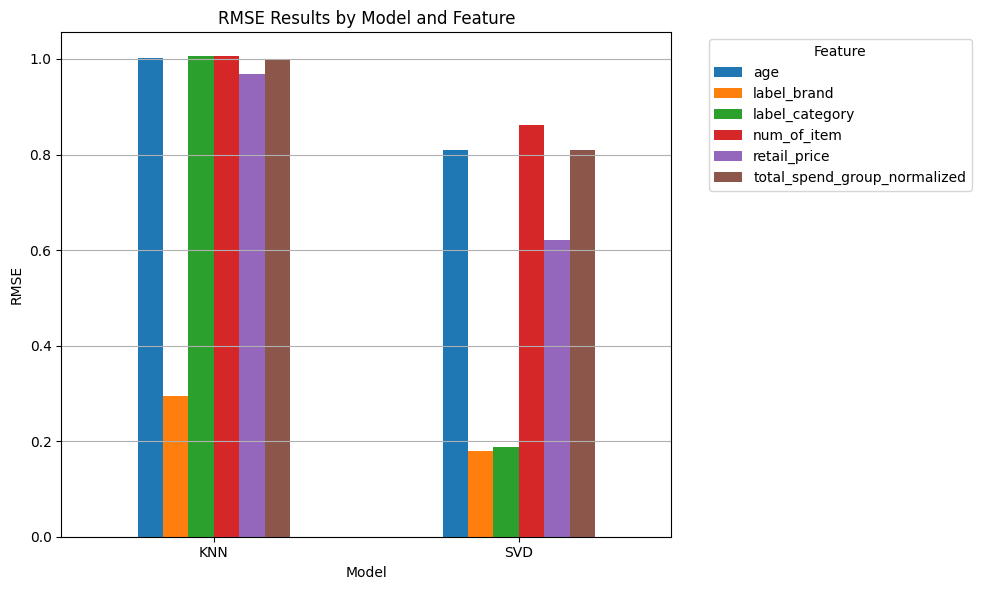

In [118]:
plt.figure(figsize=(20,8))
pivot_df.plot(kind='bar', figsize=(10, 6))
plt.title('RMSE Results by Model and Feature')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.xticks(rotation=0)  # Rotate x labels for better readability
plt.legend(title='Feature', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y')
plt.tight_layout()  # Adjust layout to make room for the labels
plt.show()

## Lưu model

In [139]:
joblib.dump(svd_model, 'svd_model.pkl')

['svd_model.pkl']